# Introduction

1. 這份 notebook 包含以下策略：
- S0: baseline: 只做單一時期進貨策略
- S1: Grid for F & R
- S2: Grid for R & Flexible F
- S12: Flexible R & Flexible F
- S14: R 與 F 的使用最佳化去找最佳解

2. 這份的 R 的範圍是設定是原本的進貨時期。
假設 T= 1~10，R 範圍則是 2~9。


# Import


In [ ]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import min_, max_
from scipy.stats import multivariate_normal, norm
import pickle
import os
import glob
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import math

params = {
    "WLSACCESSID": "bd00ac80-167a-4762-85fe-004b8045f47b",
    "WLSSECRET": "cb84ac89-30d3-4b99-874f-ebbe53176abf",
    "LICENSEID": 2563044,
}

env = gp.Env(params=params)
model = gp.Model(env=env)

# Settings


In [ ]:
import numpy as np
from datetime import datetime

#####################

salvage_value = 0
cost = 400
price = 1000
holding_cost = 0

model_prefix = f"med_{holding_cost}"

#####################

CHUNK_SIZE = 100
data_size = CHUNK_SIZE * 20
train_size = 0.5
testing_size = 0.5

T = 10
service_level = 0.95  # 服務水準
M = 5000000
LASSO_ALPHA = 0.1

ASSIGNED_FS = np.arange(0.1, 1.0, 0.1)
ASSIGNED_TS = list(range(2, T))  # 2 到 T-1
np.random.seed(0)

# Gurobi Model Constants
THREADS = 12
TIME_LIMIT = 20000
MIPGAP = 0.01
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))

# Utils


## Models' Parameters

In [ ]:
def save_model_parameters(
    name: str,
    alpha_values=None,
    beta_values=None,
    f_values=None,
    tau_values=None,
    data_size=data_size,
    current_timestamp=CURRENT_TIMESTAMP,
):
    os.makedirs("models", exist_ok=True)

    params = {}
    if alpha_values is not None:
        params["alpha"] = alpha_values
    if beta_values is not None:
        params["beta"] = beta_values
    if f_values is not None:
        params["f_values"] = f_values
    if tau_values is not None:
        params["tau_values"] = tau_values

    # 如果有參數才進行保存
    if params:
        with open(f"models/{name}_{data_size}_{current_timestamp}.pkl", "wb") as f:
            pickle.dump(params, f)
        print(
            f"Model parameters saved as models/{name}_{data_size}_{current_timestamp}.pkl"
        )
    else:
        print("No parameters provided to save.")

In [ ]:
def delete_model_parameters(name: str, data_size: int):
    # 構建檔案的路徑
    file_path = f"models/{name}_{data_size}_{CURRENT_TIMESTAMP}.pkl"

    # 檢查檔案是否存在
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Model parameters file '{file_path}' has been deleted.")
    else:
        print(f"File '{file_path}' does not exist.")

In [ ]:
def show_models(model_prefix):
    file_paths = sorted(glob.glob(f"models/{model_prefix}_*.pkl"))

    # 逐一讀取並打印每個檔案的內容
    for file_path in file_paths:
        with open(file_path, "rb") as f:
            params = pickle.load(f)
            print(f"Contents of {file_path}:")
            print(params)
            print()  # 空行分隔每個檔案的內容

In [ ]:
# show_models("linear_constraint_med_with_holding_cost")

In [ ]:
# show_models("med_with_holding_cost")

## Visualization 

In [ ]:
def plot_strategies_profits_scatter(save_type, dfs: dict):
    names = list(dfs.keys())
    df_list = [dfs[name] for name in names]

    if len(df_list) <= 1:
        print("No dataframes to plot.")
        return

    pairs = list(itertools.combinations(range(len(df_list)), 2))
    num_pairs = len(pairs)
    grid_size = math.ceil(math.sqrt(num_pairs))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle("Scatter Plots of Profits (Matrix View)")

    for idx, (i, j) in enumerate(pairs):
        row, col = divmod(idx, grid_size)
        df_i, df_j = df_list[i], df_list[j]

        if df_i is None or df_j is None or df_i.empty or df_j.empty:
            continue
        if len(df_i) != len(df_j):
            continue

        ax = axes[row, col]
        ax.scatter(df_i["profits"], df_j["profits"], alpha=0.6)
        ax.plot(
            [
                min(df_i["profits"].min(), df_j["profits"].min()),
                max(df_i["profits"].max(), df_j["profits"].max()),
            ],
            [
                min(df_i["profits"].min(), df_j["profits"].min()),
                max(df_i["profits"].max(), df_j["profits"].max()),
            ],
            "k--",
            linewidth=1,
        )
        ax.set_xlabel(names[i])
        ax.set_ylabel(names[j])
        ax.set_title(f"{names[i]} vs {names[j]}")

    # Remove empty subplots
    for idx in range(num_pairs, grid_size * grid_size):
        row, col = divmod(idx, grid_size)
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/plot_strategies_profits_scatter_{save_type}.png"
    plt.savefig(save_path, bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    plt.show()
    plt.close()

In [ ]:
def plot_relative_profit_deviation(save_type, baseline_profit, max_profits):
    """
    繪製多個策略相對於基準的平均利潤偏差。

    :param baseline_profit: 基準利潤值
    :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
    """
    print(f"Baseline is: {baseline_profit}")
    for i, profit in enumerate(max_profits):
        print(f"S{i+1}'s profit: {profit}")

    # 計算相對值
    ratios = {}
    for idx, max_profit in enumerate(max_profits, start=1):
        if max_profit is not None and max_profit != -1:
            if baseline_profit != 0:
                ratio = (max_profit - baseline_profit) / abs(baseline_profit)
                ratios[f"S{idx}"] = ratio
            else:
                # 基準利潤為零時，直接記錄增量
                ratio = max_profit
                ratios[f"S{idx}"] = ratio

    # 設置 y 軸範圍
    if ratios:
        y_min = min(ratios.values()) - 0.1
        y_max = max(ratios.values()) + 0.1
    else:
        y_min, y_max = -0.1, 0.1

    # 創建圖表顯示結果
    plt.figure(figsize=(12, 8))

    if ratios:
        bars = plt.bar(
            ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
        )

        # 在每個柱狀圖上標出數值
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.4f}",
                ha="center",
                va="bottom",
            )

    # 添加基準線，表示基準值（No Opt）
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # 設置圖表標題和軸標籤
    plt.title("Relative Avg Profit Deviation from Baseline (1)")
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline (1)")
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_deviation"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [ ]:
def plot_relative_profit_comparison(
    save_type,
    train_baseline_profit,
    test_baseline_profit,
    test_max_profits,
    train_max_profits,
):

    # Calculate relative deviations from baseline for test and train data
    test_ratios, train_ratios = {}, {}
    for idx, (test_profit, train_profit) in enumerate(
        zip(test_max_profits, train_max_profits), start=1
    ):
        if test_profit is not None and test_profit != -1:
            if test_baseline_profit != 0:
                test_ratio = (test_profit - test_baseline_profit) / abs(
                    test_baseline_profit
                )  # Relative deviation
            else:
                test_ratio = test_profit  # Use profit directly if baseline is zero
            test_ratios[f"S{idx}"] = test_ratio

        if train_profit is not None and train_profit != -1:
            if train_baseline_profit != 0:
                train_ratio = (train_profit - train_baseline_profit) / abs(
                    train_baseline_profit
                )  # Relative deviation
            else:
                train_ratio = train_profit  # Use profit directly if baseline is zero
            train_ratios[f"S{idx}"] = train_ratio

    # Define the fixed range of the y-axis
    max_value = max(
        max(test_ratios.values(), default=0), max(train_ratios.values(), default=0)
    )
    y_max = min(max_value + 0.1, 1.0)  # Limit max y to 1.0
    y_min = -y_max  # Keep symmetric scaling

    # Ensure y-axis tick marks are at intervals of 0.05
    y_ticks = np.arange(y_min, y_max + 0.05, 0.05)  # Generate ticks

    # Create bar plot for relative profit deviation comparison
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    indices = np.arange(len(train_ratios))

    # Plot bars for train and test ratios, with train on the left for each pair
    train_bars = plt.bar(
        indices - bar_width / 2,
        train_ratios.values(),
        bar_width,
        label="Train Data",
        color="salmon",
    )
    test_bars = plt.bar(
        indices + bar_width / 2,
        test_ratios.values(),
        bar_width,
        label="Test Data",
        color="skyblue",
    )

    # Add baseline line
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # Add labels for each bar
    for bar in train_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )
    for bar in test_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )

    # Set plot labels and title
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline")
    plt.title("Relative Profit Deviation Comparison between Train and Test Data")
    plt.xticks(indices, train_ratios.keys())

    # Set fixed y-axis range and ticks
    plt.ylim(y_min, y_max)
    plt.yticks(y_ticks)  # Apply fixed 0.05 intervals

    plt.legend()

    name = "plot_relative_profit_comparison"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [ ]:
def plot_Q0_Q1_distribution(save_type, stimulation_results_dfs):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is None or len(df) == 0:
            continue

        df["Q0"] = pd.to_numeric(df["Q0"], errors="coerce")
        df["Q1"] = pd.to_numeric(df["Q1"], errors="coerce")
        df.dropna(subset=["Q0", "Q1"], inplace=True)

        plt.figure(figsize=(10, 6))
        plt.hist(df["Q0"], bins=20, alpha=0.6, label="Q0", edgecolor="black")
        plt.hist(df["Q1"], bins=20, alpha=0.6, label="Q1", edgecolor="black")
        plt.title(f"Histogram of Q0 and Q1 for stimulation_results_df_{idx}")
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)

        name = "plot_Q0_Q1_distribution"

        os.makedirs("plots", exist_ok=True)
        save_path = (
            f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
        )

        plt.savefig(save_path, format="png", bbox_inches="tight")
        print(f"Plot saved as {save_path}")

        plt.show()

In [ ]:
import seaborn as sns


def plot_profits_deviation_box_plot(
    save_type, stimulation_results_dfs, baseline_avg_profits
):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is not None and "profits" in df.columns:
            df["profits"] = pd.to_numeric(df["profits"], errors="coerce")
            df.dropna(subset=["profits"], inplace=True)

            # Calculate deviation
            df["Deviation"] = df["profits"] - baseline_avg_profits

            # Plot deviation as a boxplot
            plt.figure(figsize=(8, 6))
            sns.boxplot(y=df["Deviation"])
            plt.axhline(0, color="red", linestyle="--", label="Baseline")
            plt.title(
                f"Boxplot of Deviation of Profits from Baseline for stimulation_results_df_{idx}"
            )
            plt.ylabel("Deviation")
            plt.legend()
            plt.grid(True, axis="y")

            name = "plot_profits_deviation_box_plot"

            os.makedirs("plots", exist_ok=True)
            save_path = (
                f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
            )

            plt.savefig(save_path, format="png", bbox_inches="tight")
            print(f"Plot saved as {save_path}")

            plt.show()
        else:
            print(f"Skipping stimulation_results_df_{idx}: Missing 'profits' column.")

## Others

In [ ]:
# 線性模型預測公式
def compute_f_F_Q(X_data, alphas, Q_star):
    f = sum(X_data[j] * alphas[j] for j in range(len(alphas)))
    big_f = 1 / (1 + np.exp(-f))
    q0 = big_f * Q_star
    print(f"f_vars[i]: {f:.4f}, F_vars[i]: {big_f:.4f}, Q0_vars[i]: {q0:.4f}")
    return f, big_f, q0

In [ ]:
import math


def truncate_to_2(x):
    return math.floor(x * 100) / 100

In [ ]:
# Function to replace negative values with 0
def replace_negative_with_zero(df):
    return df.applymap(lambda x: max(x, 0))

In [ ]:
def check_values(
    Q1_vars,
    Q_hat_adjusteds,
    Q0_vars,
    Sold_0s,
    total_demand_up_to_k_minus_1_vars,
    Sold_1s,
    total_demand_from_k_to_T_vars,
    Q1_plus_lefts,
    Left_0s,
    Lost_0s,
    Left_1s,
    Lost_1s,
):

    # 用於存儲每個條件的統計結果
    results = {
        "Condition": [],
        "Average_Error_Percentage": [],
        "Max_Error_Percentage": [],
        "Min_Error_Percentage": [],
        "Max_Error": [],
        "Min_Error": [],
    }

    # 定義存儲每個條件下的誤差和誤差百分比
    conditions_errors = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 存儲每個條件下的誤差百分比
    conditions_error_percentage = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 遍歷每一個變量集合
    for i in range(len(Q1_vars)):
        # 提取變量的值
        Q1 = Q1_vars[i].X
        Q_hat_adjusted = Q_hat_adjusteds[i].X
        Q0 = Q0_vars[i].X
        Sold_0 = Sold_0s[i].X
        total_demand_up_to_k_minus_1 = total_demand_up_to_k_minus_1_vars[i].X
        Sold_1 = Sold_1s[i].X
        total_demand_from_k_to_T = total_demand_from_k_to_T_vars[i].X
        Q1_plus_left = Q1_plus_lefts[i].X
        Left_0 = Left_0s[i].X
        Lost_0 = Lost_0s[i].X
        Left_1 = Left_1s[i].X
        Lost_1 = Lost_1s[i].X

        # 計算理論值
        theoretical_sold_0 = min(total_demand_up_to_k_minus_1, Q0)
        theoretical_left_0 = max(Q0 - theoretical_sold_0, 0)
        theoretical_Q1_plus_left = Q1 + theoretical_left_0  # Q1_plus_left 的理論值
        theoretical_sold_1 = min(total_demand_from_k_to_T, theoretical_Q1_plus_left)
        theoretical_left_1 = max(theoretical_Q1_plus_left - theoretical_sold_1, 0)
        theoretical_lost_0 = max(total_demand_up_to_k_minus_1 - Q0, 0)
        theoretical_lost_1 = max(total_demand_from_k_to_T - theoretical_Q1_plus_left, 0)

        # 檢查條件 2：Sold_0 一定等於理論值
        if not (Sold_0 == theoretical_sold_0):
            error = abs(Sold_0 - theoretical_sold_0)
            conditions_errors["Sold_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_0s"].append(
                (error / theoretical_sold_0) * 100 if theoretical_sold_0 != 0 else 0
            )

        # 檢查條件 3：Sold_1 一定等於理論值
        if not (Sold_1 == theoretical_sold_1):
            error = abs(Sold_1 - theoretical_sold_1)
            conditions_errors["Sold_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_1s"].append(
                (error / theoretical_sold_1) * 100 if theoretical_sold_1 != 0 else 0
            )

        # 檢查條件 4：Left_0 一定等於理論值
        if not (Left_0 == theoretical_left_0):
            error = abs(Left_0 - theoretical_left_0)
            conditions_errors["Left_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_0s"].append(
                (error / theoretical_left_0) * 100 if theoretical_left_0 != 0 else 0
            )

        # 檢查條件 5：Left_1 一定等於理論值
        if not (Left_1 == theoretical_left_1):
            error = abs(Left_1 - theoretical_left_1)
            conditions_errors["Left_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_1s"].append(
                (error / theoretical_left_1) * 100 if theoretical_left_1 != 0 else 0
            )

        # 檢查條件 6：Lost_0 一定等於理論值
        if not (Lost_0 == theoretical_lost_0):
            error = abs(Lost_0 - theoretical_lost_0)
            conditions_errors["Lost_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_0s"].append(
                (error / theoretical_lost_0) * 100 if theoretical_lost_0 != 0 else 0
            )

        # 檢查條件 7：Lost_1 一定等於理論值
        if not (Lost_1 == theoretical_lost_1):
            error = abs(Lost_1 - theoretical_lost_1)
            conditions_errors["Lost_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_1s"].append(
                (error / theoretical_lost_1) * 100 if theoretical_lost_1 != 0 else 0
            )

    # 計算每個條件的統計結果
    for condition, errors in conditions_errors.items():
        error_percentages = conditions_error_percentage[condition]
        if errors:
            # 統計數據，並將所有數值四捨五入至小數點后三位
            avg_error_percentage = (
                round(sum(error_percentages) / len(error_percentages), 3)
                if error_percentages
                else 0.0
            )
            max_error_percentage = (
                round(max(error_percentages), 3) if error_percentages else 0.0
            )
            min_error_percentage = (
                round(min(error_percentages), 3) if error_percentages else 0.0
            )
            max_error = round(max(errors), 3) if errors else 0.0
            min_error = round(min(errors), 3) if errors else 0.0

            # 存儲結果
            results["Condition"].append(condition)
            results["Average_Error_Percentage"].append(avg_error_percentage)
            results["Max_Error_Percentage"].append(max_error_percentage)
            results["Min_Error_Percentage"].append(min_error_percentage)
            results["Max_Error"].append(max_error)
            results["Min_Error"].append(min_error)

    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
# Calculate service level
def calculate_service_level(*, salvage_value, cost, price):

    cu = price - cost
    co = cost - salvage_value
    service_lv = cu / (co + cu)

    return service_lv

In [ ]:
calculate_service_level(salvage_value=salvage_value, cost=cost, price=price)

In [ ]:
def make_s3_related_strtegies_result(
    *,
    all_Rs,
    losses,
    lefts,
    profits,
    operation_profits,
    alpha_values,
    beta_values,
    F_vars,
    Q0_vars,
    Q1_vars,
    f_values,
    tau_values,
    all_left0s,
    all_left1s,
    all_lost0s,
    all_lost1s,
    results_dict: dict | None = None,
    simulations_result: dict | None = None,
) -> tuple[dict, dict]:
    results_dict = {
        "average_profits": [sum(profits) / len(profits) if len(profits) > 0 else 0],
        "average_losses": [sum(losses) / len(losses) if len(losses) > 0 else 0],
        "average_lefts": [sum(lefts) / len(lefts) if len(lefts) > 0 else 0],
        "average_operation_profits": [
            (
                sum(operation_profits) / len(operation_profits)
                if len(operation_profits) > 0
                else 0
            )
        ],
        "alpha_values": [alpha_values],
        "beta_values": [beta_values],
        "tau_values": [tau_values],
    }

    stimulations_result = {
        "R(T)": all_Rs,
        "losses": losses,
        "lefts": lefts,
        "profits": profits,
        "operation_profits": operation_profits,
        "F_vars": F_vars,
        "Q0_vars": Q0_vars,
        "Q1_vars": Q1_vars,
        "f_values": f_values,
        "left0s": all_left0s,
        "left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    if results_dict:
        results_dict.update(results_dict)
    if simulations_result:
        stimulations_result.update(simulations_result)

    # return (
    #     pd.DataFrame(results_dict).sort_values(by="average_profits", ascending=False),
    #     pd.DataFrame(stimulations_result),
    # )

    return results_dict, stimulations_result

# Generate Data


## Data1: Training data for LR


### Making full data


In [ ]:
np.random.seed(0)

# full_df = pd.DataFrame(
#     {
#         "X1": np.zeros(data_size),
#         "X2": np.zeros(data_size),
#         "X3": np.zeros(data_size),
#         "X4": np.random.uniform(5, 15, data_size),
#     }
# )

full_df = pd.DataFrame(
    {
        "X1": np.zeros(data_size),
        "X2": np.zeros(data_size),
        "X3": np.zeros(data_size),  # 將作為轉折時間
        # "X4": np.random.uniform(5, 15, data_size),
    }
)

for i in range(0, data_size, CHUNK_SIZE):
    half_chunk = CHUNK_SIZE // 2
    # 訓練 (前 half_chunk)
    full_df.loc[i : i + half_chunk - 1, "X1"] = np.random.uniform(
        15, 20, size=half_chunk
    )
    full_df.loc[i : i + half_chunk - 1, "X2"] = 0
    full_df.loc[i : i + half_chunk - 1, "X3"] = np.random.uniform(
        250, 300, size=half_chunk
    )

    # 測試 (後 half_chunk)
    full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X1"] = np.random.uniform(
        15, 20, size=half_chunk
    )
    full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X2"] = 1
    full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X3"] = np.random.uniform(
        60, 70, size=half_chunk
    )


# # 初始化 X3
# X3_values = np.zeros(data_size)

# # 對每個 chunk 設定對應的 X3 範圍
# for i in range(0, data_size, CHUNK_SIZE):
#     half_chunk = CHUNK_SIZE // 2
#     # 訓練資料 X3：200~250
#     X3_values[i : i + half_chunk] = np.random.uniform(
#         250, 300, size=min(half_chunk, data_size - i)
#     )
#     # 測試資料 X3：40~90
#     X3_values[i + half_chunk : i + CHUNK_SIZE] = np.random.uniform(
#         50, 100, size=min(half_chunk, data_size - i - half_chunk)
#     )

# # 填入 full_df
# full_df["X3"] = X3_values
full_df

In [ ]:
# np.random.seed(0)

# # 初始化 full_df，包含 X1, X2, X3, X4
# # 其他變數 (例如 X4) 用 uniform 隨機數
# full_df = pd.DataFrame(
#     {
#         "X1": np.zeros(data_size),
#         "X2": np.zeros(data_size),
#         "X3": np.zeros(data_size),  # 將作為轉折時間
#         # "X4": np.random.uniform(5, 15, data_size),
#     }
# )

# # # 根據 chunk，對第一半 (訓練) 設定 X1=1，對第二半 (測試) 設定 X2=1，
# # # 並設定 X3 為轉折時間:
# # #  訓練：X3 ~ Uniform(7, 9)
# # #  測試：X3 ~ Uniform(2, 4)
# # for i in range(0, data_size, CHUNK_SIZE):
# #     half_chunk = CHUNK_SIZE // 2
# #     # 訓練 (前 half_chunk)
# #     full_df.loc[i : i + half_chunk - 1, "X1"] = 1
# #     full_df.loc[i : i + half_chunk - 1, "X2"] = 0
# #     full_df.loc[i : i + half_chunk - 1, "X3"] = np.random.uniform(7, 9, size=half_chunk)

# #     # 測試 (後 half_chunk)
# #     full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X1"] = 0
# #     full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X2"] = 1
# #     full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X3"] = np.random.uniform(
# #         2, 4, size=half_chunk
# #     )

# for i in range(0, data_size, CHUNK_SIZE):
#     half_chunk = CHUNK_SIZE // 2
#     # 訓練部分（前 half_chunk）
#     full_df.loc[i : i + half_chunk - 1, "X1"] = 250
#     full_df.loc[i : i + half_chunk - 1, "X2"] = 0
#     full_df.loc[i : i + half_chunk - 1, "X3"] = np.random.uniform(6, 8, size=half_chunk)

#     # 測試部分（後 half_chunk）
#     full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X1"] = 100
#     full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X2"] = 1
#     full_df.loc[i + half_chunk : i + CHUNK_SIZE - 1, "X3"] = np.random.uniform(
#         2, 4, size=half_chunk
#     )

# # 顯示 full_df（部分）
# full_df.head(30)

In [ ]:
features_num = full_df.shape[1]
features_num

### Split training and testing data


In [ ]:
# from sklearn.preprocessing import StandardScaler


# def train_data_split_and_normalized(data, train_size=0.5):
#     folds = []
#     scalers = []

#     # 計算訓練集的大小
#     train_len = int(len(data) * train_size)

#     # 將資料切分為前半部分為訓練集，後半部分為測試集
#     train_data = data.iloc[:train_len].reset_index(drop=True)
#     test_data = data.iloc[train_len:].reset_index(drop=True)

#     # # 標準化處理
#     # scaler = StandardScaler()
#     # train_data_normalized = scaler.fit_transform(train_data)
#     # test_data_normalized = scaler.transform(test_data)

#     # # 將標準化資料轉回 DataFrame
#     # train_data_normalized = pd.DataFrame(train_data_normalized, columns=data.columns)
#     # test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

#     # # 將資料加入 folds 與 scaler
#     # folds.append((train_data_normalized, test_data_normalized))
#     # scalers.append(scaler)

#     # 將資料加入 folds 與 scaler
#     folds.append((train_data, test_data))
#     scalers.append(None)

#     return folds, scalers


# training_data_folds, scalers = train_data_split_and_normalized(full_df, train_size)

# for i, (train, test) in enumerate(training_data_folds):
#     print(f"Fold {i + 1}:")
#     print(f"Train size: {train.shape}, Test size: {test.shape}")
#     print("Train (normalized):")
#     print(train.head())
#     print("Test (normalized):")
#     print(test.head())
#     print()

In [ ]:
from sklearn.preprocessing import StandardScaler


def train_data_split_and_normalized_k_fold(data, train_size=0.5, chunk_size=CHUNK_SIZE):

    folds = []
    scalers = []
    train_chunk = int(train_size * chunk_size)
    n = len(data)

    # 依序將資料切分成 chunk_size 大小的子集
    for start in range(0, n, chunk_size):
        if start + chunk_size > n:
            break  # 若剩餘資料不足一個完整的 chunk，則跳過
        chunk = data.iloc[start : start + chunk_size].reset_index(drop=True)
        train_data = chunk.iloc[:train_chunk].reset_index(drop=True)
        test_data = chunk.iloc[train_chunk:].reset_index(drop=True)

        # # 建立並使用 StandardScaler 分別標準化當前的訓練與測試資料
        # scaler = StandardScaler()
        # train_data_normalized = scaler.fit_transform(train_data)
        # test_data_normalized = scaler.transform(test_data)

        # # 轉回 DataFrame 格式
        # train_data_normalized = pd.DataFrame(
        #     train_data_normalized, columns=data.columns
        # )
        # test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

        # folds.append((train_data_normalized, test_data_normalized))
        # scalers.append(scaler)

        folds.append((train_data, test_data))
        scalers.append(None)

    return folds, scalers


training_data_folds, scalers = train_data_split_and_normalized_k_fold(full_df)

for i, (train, test) in enumerate(training_data_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print("Train (normalized):")
    print(train.shape)
    print(train.head())
    print("Test (normalized):")
    print(test.shape)
    print(test.head())
    print()

## Data2: demand_df


### mu of each time(t)


In [ ]:
# 設定 b0, b1, b2
b0 = 0
b1 = 0
b2 = 0
b3 = 1
# b4 = 0
bt = 0


def cal_mu_matrix_with_random_noise(data_size, T, training_df, sigma_t):
    np.random.seed(0)

    # 初始化 mu_matrix
    mu_matrix = np.zeros((data_size, T))

    # 生成每個 t 的隨機數
    random_noises = np.random.normal(0, sigma_t, T)

    # 計算 mu_matrix
    for t in range(1, T + 1):
        mu_matrix[:, t - 1] = (
            b0 * random_noises[t - 1]
            + b1 * training_df["X1"]
            + b2 * training_df["X2"]
            + b3 * training_df["X3"]
            # + b4 * training_df["X4"]
            + bt * t
        )

    return mu_matrix


mu_matrix = cal_mu_matrix_with_random_noise(data_size, T, full_df, sigma_t=1)

print(f"mu_matrix shape: {mu_matrix.shape}")
print(f"mu_matrix[:3]: \n{mu_matrix[:3]}")
print(
    f"mu_matrix[CHUNK_SIZE : CHUNK_SIZE + 3]: \n{mu_matrix[CHUNK_SIZE : CHUNK_SIZE + 3]}"
)


mu_df = pd.DataFrame(mu_matrix, columns=[f"t{t}" for t in range(1, T + 1)])
mu_df.head(30)

In [ ]:
# def cal_mu_matrix_with_turning_point(
#     data_size, T, training_df, sigma_t, delta=50, gamma=1.0
# ):
#     np.random.seed(0)
#     mu_matrix = np.zeros((data_size, T))
#     random_noises = np.random.normal(0, sigma_t, T)

#     # 用 X1, X2 區分高低 baseline，X3 作為轉折點
#     for i in range(data_size):
#         # 根據 X1 / X2 決定 baseline range
#         if training_df.loc[i, "X2"] == 1:

#             # 低 baseline
#             # baseline1 = np.random.uniform(50, 100)
#             # baseline2 = np.random.uniform(100, 150)
#             baseline1 = np.random.uniform(100, 120)
#             baseline2 = np.random.uniform(160, 180)

#         else:
#             # 高 baseline
#             baseline1 = np.random.uniform(120, 140)
#             baseline2 = np.random.uniform(160, 180)

#         # 將 X3 視為轉折點
#         t_switch = training_df.loc[i, "X3"]

#         # 對於每一個時間點，生成一個平滑轉折項
#         for t in range(1, T + 1):
#             # 基本線性部分：當 t < t_switch 則為 baseline1，之後用 baseline2
#             if t < t_switch:
#                 mu_base = baseline1
#             else:
#                 mu_base = baseline2
#             # 加上轉折項（使轉折更平滑或更明顯）
#             turning_term = delta / (1 + np.exp(-gamma * (t - t_switch)))
#             mu_matrix[i, t - 1] = mu_base + turning_term
#     return mu_matrix


# mu_matrix = cal_mu_matrix_with_turning_point(
#     data_size, T, full_df, 1, delta=50, gamma=1.0
# )
# mu_df = pd.DataFrame(mu_matrix, columns=[f"t{t}" for t in range(1, T + 1)])
# mu_df.head(30)

In [ ]:
# 每一筆 row 的總和
row_sums = mu_df.sum(axis=1)

# 前 25 筆 row 的總和平均
first_25_avg = row_sums.head(25).mean()

# 後 25 筆（第 6 到第 30 筆）的 row 總和平均
last_25_avg = row_sums.iloc[5:30].mean()

print("前 25 筆資料的 row 總和平均：", first_25_avg)
print("後 25 筆資料的 row 總和平均：", last_25_avg)

In [ ]:
# 現在我們從 full_df 中取出第一個 chunk（共 CHUNK_SIZE 筆），並分別選出前 3 筆訓練與後 3 筆測試觀測
chunk_indices = range(0, CHUNK_SIZE)
train_indices = [i for i in chunk_indices if full_df.loc[i, "X2"] == 0][:3]
test_indices = [i for i in chunk_indices if full_df.loc[i, "X2"] == 1][:3]

print("Train indices:", train_indices)
print("Test indices:", test_indices)

# 繪圖：X軸為 t=1..T, Y軸為 mu
plt.figure(figsize=(12, 5))

# 畫出訓練資料趨勢
plt.subplot(1, 2, 1)
for i in train_indices:
    plt.plot(range(1, T + 1), mu_matrix[i, :], marker="o", label=f"Train {i}")
plt.title("Train Demand Trend")
plt.xlabel("Time Period")
plt.ylabel("Demand Mean (mu)")
plt.legend()

# 畫出測試資料趨勢
plt.subplot(1, 2, 2)
for i in test_indices:
    plt.plot(range(1, T + 1), mu_matrix[i, :], marker="o", label=f"Test {i}")
plt.title("Test Demand Trend")
plt.xlabel("Time Period")
plt.ylabel("Demand Mean (mu)")
plt.legend()

plt.tight_layout()
plt.show()

### sigma matrix


In [ ]:
X = full_df.values
feature_num = X.shape[1]
print(f"X.shape: {X.shape}")

# 生成輸入特徵矩陣 X (shape: feature_num * data_size)
np.random.seed(0)

# 隨機生成常數項 c 和係數向量 coefficients
c = np.random.uniform(0, 1)
coefficients = np.random.uniform(-1, 1, (feature_num, T))  # shape: (feature_num, T)

print(f"coefficients.shape: {coefficients.shape}")
print(f"coefficients: {coefficients}")

In [ ]:
# 進行矩陣運算
# X.T 的形狀為 (data_size, feature_num)，X.T @ coefficients 的形狀為 (feature_num, T)
linear_combination = c + X @ coefficients

# 使用 sigmoid 函數將值映射到 [0, 1] 之間
sigma_matrix = 1 / (1 + np.exp(-linear_combination))  # shape: (data_size, T)
# print(f"sigma_matrix.shape: {sigma_matrix.shape}")
# print(f"sigma_matrix: {sigma_matrix}")

# 計算每個元素的最小值和最大值
min_value = np.min(sigma_matrix)
max_value = np.max(sigma_matrix)
print(f"Value range: {(min_value, max_value)}")

# 再將值縮放到 [2, 10] 的範圍
# shape: (data_size, T)
# sigma_matrix = 0 + sigma_matrix * 300

# sigma_matrix = 0 + sigma_matrix * 200
# sigma_matrix = 100 + sigma_matrix * 100
# sigma_matrix = 0 + sigma_matrix * 10
sigma_matrix = 0 + sigma_matrix * 3
# sigma_matrix = 50 + sigma_matrix * 50
# sigma_matrix = 0 + sigma_matrix * 2
# sigma_matrix = 10 + sigma_matrix * 5
# sigma_matrix = 0 + sigma_matrix * 1


# sigma_matrix = 0 + sigma_matrix * 80
# sigma_matrix = 40 + sigma_matrix * 40
# sigma_matrix = 0 + sigma_matrix * 40
# sigma_matrix = 20 + sigma_matrix * 20
# sigma_matrix = 0 + sigma_matrix * 5

# sigma_matrix = 0 + sigma_matrix * 8
# sigma_matrix = 4 + sigma_matrix * 4
# sigma_matrix = 0 + sigma_matrix * 4
# sigma_matrix = 2 + sigma_matrix * 2
# sigma_matrix = 0 + sigma_matrix * 0.3

# 計算每個元素的最小值和最大值
min_value = np.min(sigma_matrix)
max_value = np.max(sigma_matrix)
print(f"New Value range: {(min_value, max_value)}")

# 輸出 sigma_matrix 的形狀和內容
sigma_matrix_shape = sigma_matrix.shape
sigma_matrix_content = sigma_matrix

sigma_matrix_shape, sigma_matrix_content

### corr matrix


In [ ]:
# Generate correlation matrix
np.random.seed(0)

A = np.random.uniform(-1, 1, (T, T))
corr_matrix = np.dot(A, A.T)

D = np.diag(1 / np.sqrt(np.diag(corr_matrix)))
corr_matrix = D @ corr_matrix @ D

print(f"corr_matrix shape: {corr_matrix.shape}")
print(f"corr_matrix: \n{corr_matrix}")

### cov matrix


In [ ]:
# Generate covariance matrices
cov_matrices = []
for i in range(data_size):
    cov_matrix = np.zeros((T, T))  # 每一個模擬都會有 T*T 的共變異矩陣
    for j in range(T):
        for k in range(T):
            cov_matrix[j, k] = (
                corr_matrix[j, k] * sigma_matrix[i, j] * sigma_matrix[i, k]
            )
    cov_matrices.append(cov_matrix)

print(f"cov_matrices shape: {np.array(cov_matrices).shape}")
print(f"cov_matrices: \n{cov_matrices[0]}")

In [ ]:
def is_positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)


positive_definite_check = all(is_positive_definite(cov) for cov in cov_matrices)
print("All covariance matrices are positive definite:", positive_definite_check)

### MVN stimulation for demand_df


In [ ]:
def simulate_demand_data(data_size, T, cov_matrices, mu_matrix):
    np.random.seed(0)

    simulated_data = np.array(
        [
            np.random.multivariate_normal(mu_matrix[i], cov_matrices[i])
            for i in range(data_size)
        ]
    )

    demand_df = pd.DataFrame(
        simulated_data, columns=[f"demand_t{t}" for t in range(1, T + 1)]
    )
    return demand_df


demand_df = simulate_demand_data(data_size, T, cov_matrices, mu_matrix)
demand_df

### Replace negative values to 0


In [ ]:
demand_df = replace_negative_with_zero(demand_df)
demand_df

### Validate the mean and std of total demand


檢查生成的需求數據是否符合上述總需求的特性。例如，從生成的需求 demand_df 中計算總需求
𝐷
D，然後檢查其均值和標準差是否接近理論值（即均值為所有
𝜇
𝑡
μ
t
​
的和，標準差根據共變異數矩陣計算）。


In [ ]:
def check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix):
    results = []
    for i in range(len(demand_df)):

        demand_i = demand_df.iloc[i, :]

        # theoretical mean
        theoretical_mean = mu_matrix[i].sum()

        # theoretical std
        variance_sum = np.sum(np.diag(cov_matrices[i]))
        covariance_sum = np.sum(cov_matrices[i]) - variance_sum
        theoretical_variance = variance_sum + covariance_sum
        theoretical_std = np.sqrt(theoretical_variance)

        # empirical mean and std
        empirical_mean = demand_i.sum()
        empirical_std = demand_i.std(ddof=0)  # 指定除以 n 而非 n-1
        std_relative_error = abs(theoretical_std - empirical_std) / empirical_std * 100

        # save the results
        results.append(
            {
                "theoretical_mean": theoretical_mean,
                "empirical_mean": empirical_mean,
                "theoretical_std": theoretical_std,
                "empirical_std": empirical_std,
                "std_relative_error": std_relative_error,
            }
        )

    return pd.DataFrame(results)


results_df = check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix)
results_df

### Validate normal distribution


In [ ]:
demand_df

In [ ]:
# 創建 2x5 的子圖網格
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Normal Distributions of Demand Columns")

for idx, column in enumerate(demand_df.columns):
    data = demand_df[column].dropna()  # 移除缺失值
    mean, std_dev = np.mean(data), np.std(data)

    # 產生 x 值範圍
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
    pdf = norm.pdf(x, mean, std_dev)

    # 確定當前的軸位置
    ax = axes[idx // 5, idx % 5]
    ax.hist(data, bins=15, density=True, alpha=0.6, color="skyblue")
    ax.plot(
        x,
        pdf,
        "r-",
        label=f"Normal Distribution\nMean={mean:.2f}, StdDev={std_dev:.2f}",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# 移除空白子圖（若有）
for idx in range(len(demand_df.columns), 10):
    fig.delaxes(axes[idx // 5, idx % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Validate the covariance


In [ ]:
demand_df.cov()

In [ ]:
empirical_covariance = demand_df.cov()
covariance_diff = np.abs(empirical_covariance - np.array(cov_matrices).mean(axis=0))
covariance_diff

### Validate the corr matrix of damand_df is close to original setting


In [ ]:
demand_df

In [ ]:
correlation_matrix = demand_df.corr()
print("Correlation Matrix from demand_df:")
correlation_matrix

In [ ]:
print(f"Original corr_matrix shape: {corr_matrix.shape}")
corr_matrix_df = pd.DataFrame(corr_matrix)
corr_matrix_df

### Split test and train demand_df


In [ ]:
def demand_data_split_data_k_fold(data):
    folds = []
    chunk_size = CHUNK_SIZE  # 每組 60 筆資料
    train_chunk = int(train_size * chunk_size)

    n = len(data)
    # 依序切分每一個 chunk
    for start in range(0, n, chunk_size):
        # 若剩餘資料不足 60 筆，這裡直接跳過
        if start + chunk_size > n:
            break
        chunk = data.iloc[start : start + chunk_size].reset_index(drop=True)
        train_data = chunk.iloc[:train_chunk].reset_index(drop=True)
        test_data = chunk.iloc[train_chunk:].reset_index(drop=True)
        folds.append((train_data, test_data))

    return folds


# 使用函數切分資料
demand_folds = demand_data_split_data_k_fold(demand_df)

# 印出結果，每個 fold 的訓練與測試資料
for i, (train_data, test_data) in enumerate(demand_folds, 1):
    print(f"Fold {i}:")
    print("Train Data:")
    print(train_data.shape)
    print("Test Data:")
    print(test_data.shape)
    print("=" * 40)

### Define the Q star(Q optimal)


In [ ]:
def calculate_Q_star(demand_df, service_level=0.95):

    # 計算每一行的總和
    demand_sum = demand_df.sum(axis=1)

    # 計算總和的均值和標準差
    mean_sum = demand_sum.mean()
    std_sum = demand_sum.std()

    # 計算總和的95%百分位數值
    Q_star = norm.ppf(service_level, loc=mean_sum, scale=std_sum)

    # 打印結果
    print(f"mean of sum: {mean_sum}")
    print(f"std of sum: {std_sum}")
    print(f"{service_level*100} percentile of sum: {Q_star}")

    return Q_star

In [ ]:
demand_folds

In [ ]:
# demand_df_train_1 = demand_folds[0][0]
# Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
# print(f"Q_star: {Q_star}\n")

# demand_df_train_2 = demand_folds[1][0]
# Q_star = calculate_Q_star(demand_df_train_2, service_level=0.95)
# print(f"Q_star: {Q_star}\n")

demand_df_train_1 = demand_folds[0][0]
Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
print(f"Q_star: {Q_star}\n")

## Data3: Qk hat df


### Functions


In [ ]:
# 計算條件分佈的函數
def calculate_conditional_distribution(mu, covariance_matrix, x_observed, k):
    mu_1 = mu[:k]
    mu_2 = mu[k:]
    Sigma_11 = covariance_matrix[:k, :k]
    Sigma_22 = covariance_matrix[k:, k:]
    Sigma_12 = covariance_matrix[k:, :k]
    Sigma_21 = covariance_matrix[:k, k:]

    # Compute conditional mean and covariance
    Sigma_11_inv = np.linalg.pinv(Sigma_11)
    mu_cond = mu_2 + np.dot(Sigma_12, np.dot(Sigma_11_inv, (x_observed - mu_1)))
    sigma_cond = Sigma_22 - np.dot(Sigma_12, np.dot(Sigma_11_inv, Sigma_21))

    return mu_cond, sigma_cond

In [ ]:
def cal_Var_Y(sigma_cond):

    # Extract the variances (diagonal elements)
    variances = np.diag(sigma_cond)

    # Calculate the sum of covariances (off-diagonal elements)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)

    # Total variance for the sum of mu_cond
    total_variance = np.sum(variances) + covariances_sum

    return total_variance

In [ ]:
def cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed):
    # predict_quantity = mu_cond + norm.ppf(service_level) * np.sqrt(np.diag(sigma_cond))
    # Qk_hat = x_observed.sum() + predict_quantity.sum()

    mean_Y = np.sum(mu_cond)
    var_Y = cal_Var_Y(sigma_cond)

    sd_Y = np.sqrt(var_Y)
    if sd_Y < 0 or np.isnan(sd_Y):  # scale must be positive
        sd_Y = 1e-6

    percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=sd_Y)

    # print(f"        mean_Y: {mean_Y}")
    # print(f"        sd_Y: {sd_Y}")
    # print(f"    percentile_95_Y: {percentile_95_Y}")

    Qk_hat = x_observed.sum() + percentile_95_Y
    return Qk_hat

In [ ]:
def cal_mu_and_cov_matrix(demand_df_train):

    mu_matrix = demand_df_train.mean().values
    covariance_matrix = demand_df_train.cov().values

    # print(f"mu_matrix: {mu_matrix}")
    # print(f"covariance_matrix: \n{covariance_matrix}\n")

    return mu_matrix, covariance_matrix

In [ ]:
def make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix):
    results_df = pd.DataFrame(index=demand_df.index)

    for index, row_data in demand_df.iterrows():
        for k in range(2, T + 1):
            # print(f"Now processing index: {index}, t={k}")

            x_observed = row_data[
                : k - 1
            ].values  # 取出前 k 個觀測值 -> Qk_hat_2(t=2): 則 observerd: T=1

            mu_cond, sigma_cond = calculate_conditional_distribution(
                mu_matrix, covariance_matrix, x_observed, len(x_observed)
            )

            Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)

            results_df.loc[index, f"Qk_hat_k{k}"] = Qk_hat

            # print(f"    x_observed: {x_observed}")
            # print(f"    mu_cond: {mu_cond}")
            # print(f"    sigma_cond: \n{sigma_cond}")
            # print(f"    Qk_hat: {Qk_hat}")
            # print("\n")

    return results_df

公式連結：https://jujueffectivelife.notion.site/Qk-eab4d89ec36345efbf3a0d4a4f488474?pvs=4


### Validate the consistency of condMVN in Python and R


#### Given mu and sigma


In [ ]:
from scipy.stats import multivariate_normal

# Define the mean vector and the covariance matrix
mu = np.array([10, 20, 30, 40])
covariance_matrix = np.array([[5, 1, 0, 2], [1, 8, 1, 0], [0, 1, 10, 1], [2, 0, 1, 7]])

# Mean and covariance partitioning
mu_1 = mu[:2]
mu_2 = mu[2:]
Sigma_11 = covariance_matrix[:2, :2]
Sigma_22 = covariance_matrix[2:, 2:]
Sigma_12 = covariance_matrix[2:, :2]
Sigma_21 = covariance_matrix[:2, 2:]

print(f"Sigma_11: \n{Sigma_11}\n")
print(f"Sigma_22: \n{Sigma_22}\n")
print(f"Sigma_12: \n{Sigma_12}\n")
print(f"Sigma_21: \n{Sigma_21}\n")

In [ ]:
# Observed values of X1 and X2
x_observed = np.array([6, 30])

mu_cond, sigma_cond = calculate_conditional_distribution(
    mu, covariance_matrix, x_observed, len(x_observed)
)
print(f"mu_cond: {mu_cond}")
print(f"sigma_cond: \n{sigma_cond}")

In [ ]:
# Define the conditional distribution
conditional_dist = multivariate_normal(mean=mu_cond, cov=sigma_cond)

# Values at which to evaluate the PDF and CDF
x3, x4 = 30, 40  # These can be any values of interest

# Calculate the PDF
pdf_value = conditional_dist.pdf([x3, x4])
print(f"Conditional density at X3 = {x3}, X4 = {x4}: {pdf_value}")

# Calculate the CDF
cdf_value = conditional_dist.cdf([x3, x4])
print(f"Conditional cumulative probability up to X3 = {x3}, X4 = {x4}: {cdf_value}")

# Qk hat
Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)
print(f"Qk_hat of x_observed: {Qk_hat}")

```
R 中運行的結果
```

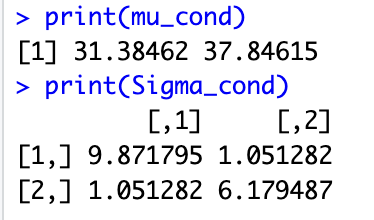
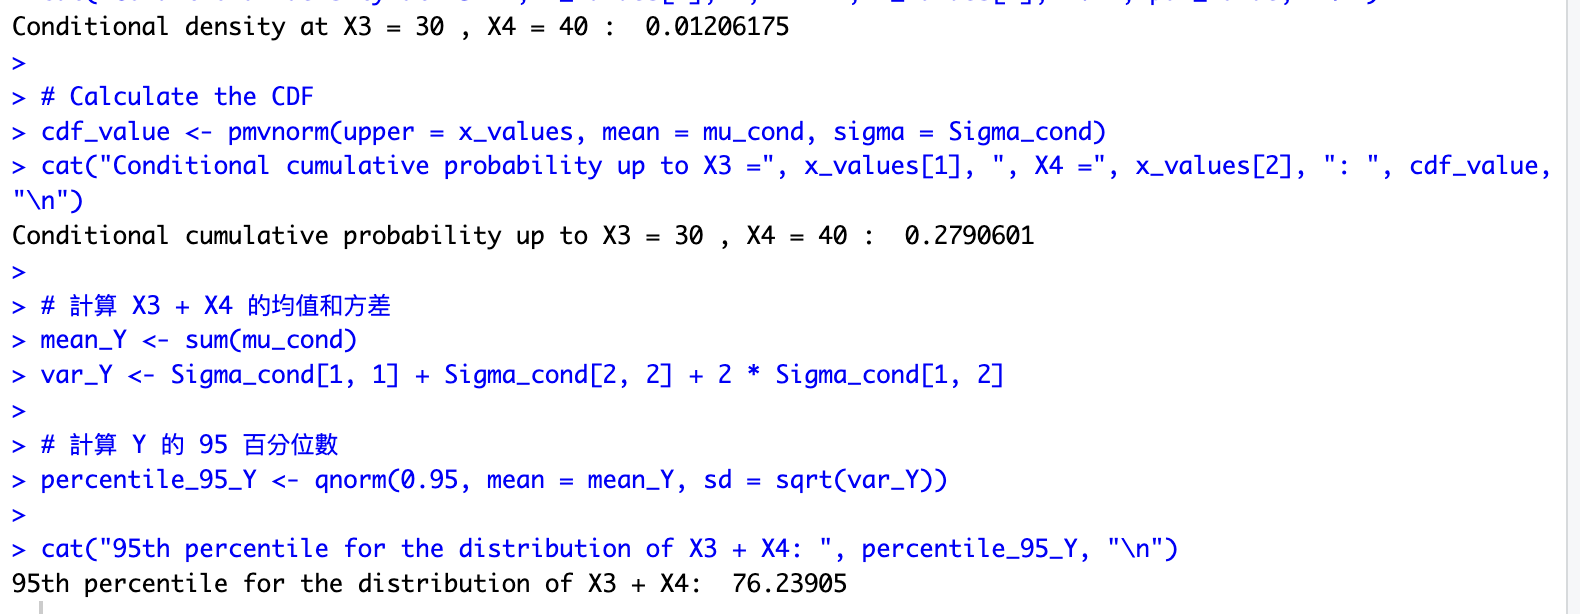


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean_Y = np.sum(mu_cond)
var_Y = cal_Var_Y(sigma_cond)

percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=np.sqrt(var_Y))

# Generate normal distribution data
x_values = np.linspace(mean_Y - 4 * np.sqrt(var_Y), mean_Y + 4 * np.sqrt(var_Y), 1000)
y_values = norm.pdf(x_values, loc=mean_Y, scale=np.sqrt(var_Y))

# Create dataframe
data = pd.DataFrame({"x": x_values, "y": y_values})

# Plot distribution
plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["y"], color="blue")
plt.axvline(x=percentile_95_Y, color="red", linestyle="dashed")
plt.fill_between(
    data["x"], data["y"], where=(data["x"] <= percentile_95_Y), color="red", alpha=0.3
)
plt.title("Distribution of X3 + X4")
plt.xlabel("Value")
plt.ylabel("Density")
plt.annotate(
    "95th Percentile",
    xy=(percentile_95_Y, max(y_values)),
    xytext=(percentile_95_Y, max(y_values) * 1.1),
    arrowprops=dict(facecolor="red", shrink=0.05),
    color="red",
    ha="center",
)
plt.show()

```
以下為 R 程式結果
```


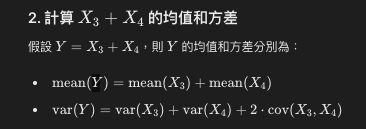


P(X3,X4∣X1=10,X2=20) 的 R 計算如下

```
install.packages("condMVNorm")
install.packages("mvtnorm")
library(condMVNorm)
library(mvtnorm)
library(ggplot2)

# Define the mean vector and covariance matrix
mu <- c(10, 20, 30, 40)
sigma <- matrix(c(
    5, 1, 0, 2,
    1, 8, 1, 0,
    0, 1, 10, 1,
    2, 0, 1, 7
), nrow = 4, byrow = TRUE)

# Observed values of X1 and X2
x_observed <- c(6, 30)

# Compute the conditional mean and covariance using condMVNorm
conditional_results <- condMVN(mean = mu, sigma = sigma, dependent.ind = c(3, 4), given.ind = c(1, 2), X.given = x_observed)

# Print the conditional mean and covariance
print(conditional_results$condMean)
print(conditional_results$condVar)

# Extract the conditional mean and covariance
mu_cond <- conditional_results$condMean
Sigma_cond <- conditional_results$condVar

# Print the conditional mean and covariance
print(mu_cond)
print(Sigma_cond)

# Values at which to evaluate the PDF and CDF
x_values <- c(30, 40)

# Calculate the PDF
pdf_value <- dmvnorm(x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional density at X3 =", x_values[1], ", X4 =", x_values[2], ": ", pdf_value, "\n")

# Calculate the CDF
cdf_value <- pmvnorm(upper = x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional cumulative probability up to X3 =", x_values[1], ", X4 =", x_values[2], ": ", cdf_value, "\n")

```


#### Conditional mean and variance


In [ ]:
def cal_Var_Y(sigma_cond):
    variances = np.diag(sigma_cond)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)
    total_variance = np.sum(variances) + covariances_sum

    return total_variance


def simulate_Y(mu_cond, sigma_cond, num_samples=10000):
    samples = np.random.multivariate_normal(mu_cond, sigma_cond, num_samples)

    Y = samples[:, 0] + samples[:, 1]

    mean_Y = np.mean(Y)
    var_Y = np.var(Y)

    return mean_Y, var_Y


mu_cond = [2, 3]
sigma_cond = [[1, 0.5], [0.5, 1]]

mean_Y_formula = np.sum(mu_cond)
var_Y_formula = cal_Var_Y(sigma_cond)

mean_Y_simulated, var_Y_simulated = simulate_Y(mu_cond, sigma_cond)

print(f"公式計算的Y的均值: {mean_Y_formula}")
print(f"公式計算的Y的方差: {var_Y_formula}")
print(f"模擬計算的Y的均值: {mean_Y_simulated}")
print(f"模擬計算的Y的方差: {var_Y_simulated}")

### Calculate Qk hat for 2~T-1 of demand_df_train


In [ ]:
demand_df_train = demand_folds[0][0]

In [ ]:
_, _ = cal_mu_and_cov_matrix(demand_df_train)

In [ ]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df)
Qk_hat_df = make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix)

In [ ]:
Qk_hat_df

### Plot the distribuction


In [ ]:
# 將 T 個時期分成三份
early_values = Qk_hat_df.iloc[:, : T // 3].mean(axis=1)
mid_values = Qk_hat_df.iloc[:, T // 3 : 2 * T // 3].mean(axis=1)
late_values = Qk_hat_df.iloc[:, 2 * T // 3 :].mean(axis=1)

# 計算與 Q_star 的差距
early_diff = early_values - Q_star
mid_diff = mid_values - Q_star
late_diff = late_values - Q_star

# 繪製直方圖
plt.figure(figsize=(12, 8))

# 早期
plt.hist(early_diff, bins=10, alpha=0.5, label="Early", color="blue", edgecolor="black")
# 中期
plt.hist(mid_diff, bins=10, alpha=0.5, label="Mid", color="green", edgecolor="black")
# 晚期
plt.hist(late_diff, bins=10, alpha=0.5, label="Late", color="red", edgecolor="black")

plt.axvline(0, color="grey", linestyle="--")

plt.xlabel("Difference from Q star")
plt.ylabel("Frequency")
plt.title("Histogram of Differences from Q star at Different Times")
plt.legend()
plt.grid(True)
plt.show()

# 計算偏差
early_bias = np.mean(early_diff)
mid_bias = np.mean(mid_diff)
late_bias = np.mean(late_diff)

print(f"Q_star is: {Q_star}")
print(f"Early bias: {early_bias}")
print(f"Mid bias: {mid_bias}")
print(f"Late bias: {late_bias}")

In [ ]:
# 繪製直方圖
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 早期
axes[0].hist(early_diff, bins=10, alpha=0.5, color="blue", edgecolor="black")
axes[0].axvline(0, color="grey", linestyle="--")
axes[0].set_title("Early")
axes[0].set_xlabel("Difference from Q star")
axes[0].set_ylabel("Frequency")

# 中期
axes[1].hist(mid_diff, bins=10, alpha=0.5, color="green", edgecolor="black")
axes[1].axvline(0, color="grey", linestyle="--")
axes[1].set_title("Mid")
axes[1].set_xlabel("Difference from Q star")
axes[1].set_ylabel("Frequency")

# 晚期
axes[2].hist(late_diff, bins=10, alpha=0.5, color="red", edgecolor="black")
axes[2].axvline(0, color="grey", linestyle="--")
axes[2].set_title("Late")
axes[2].set_xlabel("Difference from Q star")
axes[2].set_ylabel("Frequency")

fig.suptitle("Histogram of Differences from Q star at Different Times")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Strategies utils


## Validation

### Validate the r and R

In [ ]:
import gurobipy as gp
from gurobipy import GRB

# 初始化模型
# model = gp.Model("Test_r_R_relationship")
model = gp.Model(env=env)

# 設定參數
K = 4  # 候選數量
i = 0  # 單個 i 的例子

# 定義變數
r_vars = model.addVars(K, lb=0.0, ub=1.0, name="r_vars")  # r_{i,k}
R_vars = model.addVars(K, vtype=GRB.BINARY, name="R_vars")  # R_{i,k}
max_r_helper = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")  # 最大值輔助變數

# 假設 exp_tau_vars 是已知的輸入數值
exp_tau_vars = [0.1, 0.3, 0.5, 0.2]  # 例子數值

# 限制式 1: 定義 r_vars 與 exp_tau_vars 的關係
for k in range(K):
    model.addConstr(
        r_vars[k] * sum(exp_tau_vars) == exp_tau_vars[k],
        name=f"softmax_relation_{k}",
    )

# 限制式 2: 確保 r_vars 的加總為 1
model.addConstr(gp.quicksum(r_vars[k] for k in range(K)) == 1, name="sum_r_constraint")

# 限制式 3: 找出 r_vars 中的最大值
model.addGenConstrMax(
    max_r_helper, [r_vars[k] for k in range(K)], name="max_r_constraint"
)

# 限制式 4: 確保 R_vars 對應到最大值
for k in range(K):
    model.addGenConstrIndicator(
        R_vars[k], 1, r_vars[k] == max_r_helper, name=f"indicator_R_{k}"
    )

# 限制式 5: 確保僅有一個 R_vars[k] 為 1
model.addConstr(
    gp.quicksum(R_vars[k] for k in range(K)) == 1, name="unique_R_constraint"
)

# 設定目標函數（範例：最大化 max_r_helper）
model.setObjective(max_r_helper, GRB.MAXIMIZE)

# 求解模型
model.optimize()

# 輸出結果
if model.Status == GRB.OPTIMAL:
    print("Optimal solution found!")
    print(f"max_r_helper: {max_r_helper.X}")
    print("r_vars:")
    for k in range(K):
        print(f"  r_vars[{k}]: {r_vars[k].X}")
    print("R_vars:")
    for k in range(K):
        print(f"  R_vars[{k}]: {R_vars[k].X}")
else:
    print("No optimal solution found.")

檢驗結果：目前的寫法可以成功讓 r 與 R 的關係實現



## S0 - One-time Procurement


In [ ]:
def one_time_procurement(Q_star, demand_df, cost, price, salvage_value):

    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []

    for i, row in demand_df.iterrows():
        inventory = Q_star
        losses = []
        lefts = []
        daily_operation_profits = []
        daily_profits = []
        total_sold = 0  # 追蹤總售出量
        total_lost = 0  # 追蹤總丟失量

        # print("=" * 50)
        # print(
        #     f"Processing row {i+1}/{len(demand_df)} with initial inventory Q_star={Q_star}"
        # )
        # print("=" * 50)

        for day, demand in enumerate(row):
            sales = min(inventory, demand)
            loss = max(demand - inventory, 0)
            left = max(inventory - sales, 0)
            total_sold += sales
            total_lost += loss

            inventory -= sales

            # print("-" * 50)
            # print(f"Day {day+1}")
            # print(f"Demand      : {demand}")
            # print(f"Sales       : {sales}")
            # print(f"Loss        : {loss}")
            # print(f"Left        : {left}")
            # print(f"Inventory   : {inventory}")
            # print("-" * 50)

            if day == len(row) - 1:
                left_penalty_cost = (cost - salvage_value) * left
                lefts.append(left)
                # print(f"End of period: Left Penalty Cost = {left_penalty_cost}")
                # print("-" * 50)
            else:
                left_penalty_cost = 0

        operation_profit = (price - cost) * total_sold
        profit = operation_profit - left_penalty_cost - (price - cost) * total_lost

        # print("=" * 50)
        # print(f"Row {i+1} Summary")
        # print(f"Total Sold         : {total_sold}")
        # print(f"Total Lost         : {total_lost}")
        # print(f"Operation Profit   : {operation_profit}")
        # print(f"Profit             : {profit}")
        # print("=" * 50)

        all_losses.append(total_lost)
        all_lefts.append(sum(lefts))
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

    avg_losses = np.mean(all_losses)
    avg_lefts = np.mean(all_lefts)
    avg_operation_profits = np.mean(all_operation_profits)
    avg_profits = np.mean(all_profits)

    # print("=" * 50)
    # print("Overall Summary")
    # print(f"Average Losses           : {avg_losses}")
    # print(f"Average Lefts            : {avg_lefts}")
    # print(f"Average Operation Profits: {avg_operation_profits}")
    # print(f"Average Profits          : {avg_profits}")
    # print("=" * 50)

    stimulation_df = pd.DataFrame(
        {
            "losses": all_losses,
            "lefts": all_lefts,
            "operation_profits": all_operation_profits,
            "profits": all_profits,
        }
    )

    return avg_losses, avg_lefts, avg_profits, avg_operation_profits, stimulation_df

## S1 - Grid for Fixed F & Fixed Rk


In [ ]:
def cal_fixed_F_fixed_R(
    Q_star, assigned_F, assigned_R, demand_df, cost, price, salvage_value, Qk_hat_df
):
    all_losses = []
    all_lefts = []
    all_left0s = []
    all_left1s = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max((row[: assigned_R + 1].sum() - Q0), 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1
        total_left = left_0 + left_1

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold

        left_penalty_cost = (cost - salvage_value) * left_1
        # left_penalty_cost = (cost - salvage_value) * total_left
        lost_penalty_cost = (price - cost) * total_lost

        profit = operation_profit - left_penalty_cost - lost_penalty_cost

        all_losses.append(total_lost)
        all_lefts.append(total_left)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_left0s.append(left_0)
        all_left1s.append(left_1)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
    }

    return result_df, stimulation_result

In [ ]:
def grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}
    max_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:

            assigned_R = assigned_T - 1
            mean_result, stimulation_result = cal_fixed_F_fixed_R(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    return pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F(with lasso)


In [ ]:
def cal_flexible_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    lambda_alpha,
):

    with gp.Model("profit_maximization", env=env) as model:
        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("NonConvex", 2)
        model.setParam("IntFeasTol", 1e-9)
        model.setParam("NumericFocus", 3)

        # ======================= Decision Variables =======================
        alphas = model.addVars(
            features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="alphas"
        )
        abs_alphas = model.addVars(alphas.keys(), lb=0, name="abs_alpha")

        # 進行 L1 正則化處理：alphas
        for i in alphas.keys():
            model.addConstr(abs_alphas[i] >= alphas[i])
            model.addConstr(abs_alphas[i] >= -alphas[i])

        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        f_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, ub=GRB.INFINITY, name="f_var"
        )
        F_vars = model.addVars(len(demand_df_train), lb=0, ub=1, name="Fraction")

        Q0_vars = model.addVars(
            len(demand_df_train), lb=0.0, ub=(Q_star + 1), name="Q0_var"
        )
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")

        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        # ======================= Model Constraints =======================
        for i, row in demand_df_train.iterrows():
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i].tolist()
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            model.addConstr(F_vars[i] >= 0, name=f"Fraction_lower_bound_{i}")
            model.addConstr(F_vars[i] <= 1, name=f"Fraction_upper_bound_{i}")

            # Calculate F using logistic regression
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], options="FuncNonlinear=1"
            )

            # Calculate initial order quantity
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star)

            # Define demand variables for before and after reorder point
            total_demand_before_R = demand_row[: assigned_R + 1].sum()
            total_demand_after_R = demand_row[assigned_R + 1 :].sum()

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_1_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_1_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_before_R, Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux], constant=0, name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_before_R - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_before_R - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux], constant=0, name=f"Constr_Lost_0_max_{i}"
            )

            # Calculate Q1 based on reorder point estimate
            Q_hat = Qk_hat_df_row[assigned_R]
            Q_hat_adjusted = Q_hat - Q0_vars[i]
            Q_hat_adjusted_var = model.addVar(
                lb=-GRB.INFINITY, name=f"Q_hat_adjusted_{i}"
            )
            model.addConstr(Q_hat_adjusted_var == Q_hat_adjusted)

            model.addGenConstrMax(
                Q1_vars[i], [Q_hat_adjusted_var], constant=0, name=f"max_Q1_constr_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_after_R, Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux], constant=0, name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_after_R - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_after_R - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux], constant=0, name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * (Left_1s[i])  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        # Set objective
        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train)))
            - lambda_alpha * gp.quicksum(abs_alphas[i] for i in abs_alphas.keys()),
            GRB.MAXIMIZE,
        )

        model.write("s2_model_debug.lp")
        model.write("s2_model.mps")

        # Solve model
        try:
            # === 1️⃣ Solve Model ===
            model.optimize()

            if model.status in [GRB.OPTIMAL, GRB.TIME_LIMIT]:
                print(f"Model status: {model.status}")

                # === 2️⃣ Collect α parameters ===
                alpha_values = np.array([alpha.X for alpha in alphas.values()])

                # === 3️⃣ Initialize result containers ===
                results = {
                    "losses": [],
                    "lefts": [],
                    "profits": [],
                    "operation_profits": [],
                    "Q0s": [],
                    "Q1s": [],
                    "Fs": [],
                    "fs": [],
                }

                # === 4️⃣ Extract results per observation ===
                for i in range(len(demand_df_train)):
                    # Retrieve optimized variable values
                    sold0, sold1 = Sold_0s[i].X, Sold_1s[i].X
                    lost0, lost1 = Lost_0s[i].X, Lost_1s[i].X
                    left0, left1 = Left_0s[i].X, Left_1s[i].X

                    # --- (a) Aggregate losses / left stock ---
                    total_loss = lost0 + lost1
                    total_left = left0 + left1

                    # --- (b) Calculate profit components ---
                    operation_profit = (price - cost) * (sold0 + sold1)
                    total_profit = profits_vars[i].X

                    # --- (c) Record to results dict ---
                    results["losses"].append(total_loss)
                    results["lefts"].append(total_left)
                    results["operation_profits"].append(operation_profit)
                    results["profits"].append(total_profit)
                    results["Q1s"].append(Q1_vars[i].X)

                    # --- (d) Validate f, F, Q0 consistency ---
                    x_data = training_df.iloc[i].tolist() + [1]
                    f_train, F_train, Q0_train = compute_f_F_Q(
                        x_data, alpha_values, Q_star
                    )

                    if (
                        truncate_to_2(f_train) == truncate_to_2(f_vars[i].X)
                        and truncate_to_2(F_train) == truncate_to_2(F_vars[i].X)
                        and truncate_to_2(Q0_train) == truncate_to_2(Q0_vars[i].X)
                    ):
                        # print("✅ f_train, F_train, Q0_train 都相等")
                        results["fs"].append(f_vars[i].X)
                        results["Fs"].append(F_vars[i].X)
                        results["Q0s"].append(Q0_vars[i].X)
                    else:
                        # print("⚠️ f_train, F_train, Q0_train 不相等")
                        results["fs"].append(-1)
                        results["Fs"].append(-1)
                        results["Q0s"].append(-1)

                # === 5️⃣ Return structured results ===
                return (
                    [assigned_R] * len(demand_df_train),  # Fixed R for all observations
                    results["losses"],
                    results["lefts"],
                    results["profits"],
                    results["operation_profits"],
                    alpha_values,
                    results["Fs"],
                    results["fs"],
                    results["Q0s"],
                    results["Q1s"],
                )

            # === 6️⃣ Infeasible case ===
            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model status: {model.status}")

                model.computeIIS()
                model.write("model_s2.ilp")

                # Print infeasible constraints
                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"❌ 導致不可行的約束: {constr.ConstrName}")

                # Print infeasible variables
                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"❌ 不可行變數: {var.VarName}, IIS下界={var.IISLB}, IIS上界={var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"❗Gurobi Error {e.errno}: {e}")
            return None

In [ ]:
def grid_flexible_F_fixed_R(
    assigned_Ts,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "R": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "f_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        # assigned_R = assigned_T - 2
        assigned_R = assigned_T - 1

        result = cal_flexible_F_fixed_R(
            assigned_R=assigned_R,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
            lambda_alpha=LASSO_ALPHA,
        )

        if result is None:
            print(f"模型沒有最佳解")
            continue

        (
            all_Rs,
            losses,
            lefts,
            profits,
            operation_profits,
            alpha_values,
            F_vars,
            f_vars,
            Q0_vars,
            Q1_vars,
        ) = result

        # 計算平均值
        average_losses = sum(losses) / len(losses) if losses else 0
        average_lefts = sum(lefts) / len(lefts) if lefts else 0
        average_profits = sum(profits) / len(profits) if profits else 0
        average_operation_profits = (
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        )

        # 將結果存儲到字典中
        results_dict["R(T)"].append(assigned_T)
        results_dict["R"].append(all_Rs)
        results_dict["average_losses"].append(average_losses)
        results_dict["average_lefts"].append(average_lefts)
        results_dict["average_profits"].append(average_profits)
        results_dict["average_operation_profits"].append(average_operation_profits)
        results_dict["alpha_values"].append(alpha_values)
        results_dict["F_vars"].append(F_vars)
        results_dict["f_vars"].append(f_vars)
        results_dict["Q0_vars"].append(Q0_vars)
        results_dict["Q1_vars"].append(Q1_vars)

        # print(f"The average profits is {average_profits}")

        if max_profit is None or max_profit < average_profits:
            # print(f"max_profit is changed from {max_profit} to {average_profits}")
            max_profit = average_profits
            max_profit_stimulation_result = {
                "R": all_Rs,
                "F": F_vars,
                "f": f_vars,
                "profits": profits,
                "losses": losses,
                "lefts": lefts,
                "operation_profits": operation_profits,
                "Q0": Q0_vars,
                "Q1": Q1_vars,
            }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## S3 - Optimized F & Rk

In [ ]:
def __cal_optimized_F_R(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)
        model.setParam("NumericFocus", 3)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        # K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
        K = T - 1  # this is for k=2~T. => if T = 10(1~10), K will be 9. (0~8)

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            model.addConstr(F_vars[i] >= 0, name=f"Fraction_lower_bound_{i}")
            model.addConstr(F_vars[i] <= 1, name=f"Fraction_upper_bound_{i}")
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )

            model.addConstr(
                Q1_vars[i] == max_([Q_hat_adjusteds[i]], constant=0),
                name=f"Max_Constraint_{i}",
            )
            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_1_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_1_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux], constant=0, name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux], constant=0, name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux], constant=0, name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux], constant=0, name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s3_model_debug.lp")
        model.write("s3_model.mps")

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        # print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    # print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model_s3.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.ConstrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [ ]:
def cal_optimized_F_R(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df,
    Qk_hat_df,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    (
        all_Rs,
        losses,
        lefts,
        profits,
        operation_profits,
        F_vars,
        Q0_vars,
        Q1_vars,
        all_left0s,
        all_left1s,
        all_lost0s,
        all_lost1s,
    ) = __cal_optimized_F_R(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    # 計算平均值
    average_losses = sum(losses) / len(losses) if losses else 0
    average_lefts = sum(lefts) / len(lefts) if lefts else 0
    average_profits = sum(profits) / len(profits) if profits else 0
    average_operation_profits = (
        sum(operation_profits) / len(operation_profits) if operation_profits else 0
    )

    # 將結果存儲到字典中
    results_dict["R(T)"].append(all_Rs)
    results_dict["average_losses"].append(average_losses)
    results_dict["average_lefts"].append(average_lefts)
    results_dict["average_profits"].append(average_profits)
    results_dict["average_operation_profits"].append(average_operation_profits)
    results_dict["F_vars"].append(F_vars)
    results_dict["Q0_vars"].append(Q0_vars)
    results_dict["Q1_vars"].append(Q1_vars)

    # print(f"The average profits is {average_profits}")

    if max_profit is None or max_profit < average_profits:
        max_profit = average_profits
        max_profit_stimulation_result = {
            "R": all_Rs,
            "F": F_vars,
            "profits": profits,
            "losses": losses,
            "lefts": lefts,
            "operation_profits": operation_profits,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## S4 - Beta without r

In [ ]:
def __fully_flexible_beta_with_softmax_4(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)
        model.setParam("NumericFocus", 3)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        # K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
        K = T - 1  # this is for k=2~T. => if T = 10(1~10), K will be 9. (0~8)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(K, features_num + 1, lb=-GRB.INFINITY, name="betas")

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        # r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i],
                yvar=F_vars[i],
                options="FuncNonlinear=1",
                name=f"logistic_constraint_{i}",
            )

            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model(Alternative Model) ===================

            # Step 1: 利用線性回歸計算 tau
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

            delta = 1e-3
            tau_star = model.addVar(lb=-GRB.INFINITY, name=f"tau_star_{i}")

            for k in range(K):
                # 如果候選 k 被選中 (R_vars[i,k] == 1)，則強制 tau_vars[i,k] 等於 tau_star
                model.addGenConstrIndicator(
                    R_vars[i, k],
                    True,
                    tau_vars[i, k] == tau_star,
                    name=f"tau_star_eq_{i}_{k}",
                )

                # 如果候選 k 未被選中 (R_vars[i,k] == 0)，則必須有 tau_vars[i,k] <= tau_star - delta
                # 利用 Big-M 技巧：當 R_vars[i,k]==0 時，約束變為 tau_vars[i,k] <= tau_star - delta
                # 當 R_vars[i,k]==1 時，由於前面的 indicator 約束已強制 tau_vars[i,k] == tau_star，
                # 此約束則不會影響模型（因為 tau_star <= tau_star - delta + M 已經成立）
                model.addConstr(
                    tau_vars[i, k] <= tau_star - delta + M * R_vars[i, k],
                    name=f"tau_gap_{i}_{k}",
                )

            # Step 3: 保證只有一個候選被選中 (即 R_vars 為 1 的只有一個)
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"one_R_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], constant=0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_1_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_1_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux], constant=0, name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux], constant=0, name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux], constant=0, name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux], constant=0, name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * (Left_1s[i])  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )
        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                )

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)

                    all_Q1s.append(Q1_vars[i].X)
                    # all_Fs.append(F_vars[i].X)

                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    # Check f
                    x_data = training_df.iloc[i].tolist()
                    x_data.append(1)
                    f_train, F_train, Q0_train = compute_f_F_Q(
                        x_data, alpha_values, Q_star
                    )
                    if (
                        truncate_to_2(f_train) == truncate_to_2(f_vars[i].X)
                        and truncate_to_2(F_train) == truncate_to_2(F_vars[i].X)
                        and truncate_to_2(Q0_train) == truncate_to_2(Q0_vars[i].X)
                    ):
                        print("f_train, F_train, Q0_train 都相等")
                        all_Q0s.append(Q0_vars[i].X)
                        all_Fs.append(F_vars[i].X)
                    else:
                        print(f"f_train, F_train, Q0_train 不相等")
                        all_Q0s.append(-1)
                        all_Fs.append(-1)

                    reorder_day = None
                    # rs = []
                    for k in range(K):
                        # rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X

                        if int(R_value) == 1:
                            reorder_day = k + 2

                    all_Rs.append(reorder_day)
                    # all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model_s4.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.ConstrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [ ]:
def fully_flexible_beta_with_softmax_4(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_4(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result

        print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

## S5 - Beta with two phase


In [ ]:
def __build_and_optimize_base_model_5(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    alpha_init=None,
    beta_j_init=None,
    beta_k_init=None,
    A_value=None,
    rho=None,
    use_upper_bound=True,  # 是否加上 |α| ≤ |α_init| 這種限制
):
    """
    可重用的模型建構 + 最佳化函式
    --------------------------------------------------------
    第一階段：
        - 不傳入 alpha/beta，單純訓練，計算 A。
    第二階段：
        - 傳入 alpha, beta, A_value, rho
        - 模型自動加入限制：
            Σ|α| + Σ|β| ≤ ρ * A_value
        - 並可選擇加上 |α| ≤ |α_init|, |β| ≤ |β_init|
    --------------------------------------------------------
    回傳：
        model, A_value, sparsity_expr, alpha_vars, beta_j_vars, beta_k_vars, result_tuple
    """
    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)
        model.setParam("NumericFocus", 3)

        K = T - 1

        # ====== Variables ======
        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        beta_k = model.addVars(K, lb=-GRB.INFINITY, name="beta_k")
        beta_j = model.addVars(features_num, lb=-GRB.INFINITY, name="beta_j")

        # ====== Abs terms for sparsity ======
        abs_alpha = model.addVars(features_num + 1, lb=0.0, name="abs_alpha")
        abs_beta = model.addVars(features_num, lb=0.0, name="abs_beta")

        for j in range(features_num + 1):
            model.addGenConstrAbs(abs_alpha[j], alphas[j], name=f"abs_alpha_{j}")
        for j in range(features_num):
            model.addGenConstrAbs(abs_beta[j], beta_j[j], name=f"abs_beta_{j}")

        sparsity_expr = gp.quicksum(
            abs_alpha[j] for j in range(features_num + 1)
        ) + gp.quicksum(abs_beta[j] for j in range(features_num))

        A_var = model.addVar(lb=0.0, name="A_var")
        model.addConstr(A_var == sparsity_expr, name="define_A")

        # ====== Stage 2 constraints ======
        if (A_value is not None) and (rho is not None):
            cap_value = rho * A_value
            print(f"[Build] 加入第二階段限制 Σ|α|+Σ|β| ≤ {cap_value:.6f}")
            model.addConstr(sparsity_expr <= cap_value, name="sparsity_cap")

            if use_upper_bound:  # 分別的 upper bound
                # 加上 |α_j| ≤ |α_init_j|, |β_j| ≤ |β_init_j|
                if alpha_init is not None:
                    for j in range(features_num + 1):
                        model.addConstr(
                            abs_alpha[j] <= abs(alpha_init[j]), name=f"alpha_bound_{j}"
                        )
                if beta_j_init is not None:
                    for j in range(features_num):
                        model.addConstr(
                            abs_beta[j] <= abs(beta_j_init[j]), name=f"beta_bound_{j}"
                        )

        # ====== Initialize warm start if provided ======
        if alpha_init is not None:
            for j in range(features_num + 1):
                alphas[j].start = alpha_init[j]
        if beta_j_init is not None:
            for j in range(features_num):
                beta_j[j].start = beta_j_init[j]
        if beta_k_init is not None:
            for k in range(K):
                beta_k[k].start = beta_k_init[k]

        # ====== Model variables for rest of optimization ======
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")
        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")
        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(len(demand_df_train), lb=0, ub=1, name="F_var")
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(len(Qk_hat_df), lb=0.0, name="Q_hat")
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name="Q_hat_adjusted"
        )

        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train), lb=0, name="total_demand_up"
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="total_demand_down"
        )
        Q1_plus_lefts = model.addVars(len(demand_df_train), lb=0, name="Q1_plus_left")

        # ====== Constraints building ======
        for i, _ in demand_df_train.iterrows():
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)
            X_feat = training_df.iloc[i].tolist()

            # logistic for F
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], options="FuncNonlinear=1"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star)

            # tau
            j_sum = gp.quicksum(X_feat[j] * beta_j[j] for j in range(features_num))
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k] == beta_k[k] + j_sum,
                    name=f"tau_{i}_{k}",
                )

            delta = 1e-3
            tau_star = model.addVar(lb=-GRB.INFINITY, name=f"tau_star_{i}")
            for k in range(K):
                model.addGenConstrIndicator(
                    R_vars[i, k], True, tau_vars[i, k] == tau_star
                )
                model.addConstr(tau_vars[i, k] <= tau_star - delta + M * R_vars[i, k])
            model.addConstr(gp.quicksum(R_vars[i, k] for k in range(K)) == 1)

            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                )
            )
            model.addConstr(Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i])
            model.addConstr(Q1_vars[i] == gp.max_(Q_hat_adjusteds[i], constant=0))

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_1_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_1_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux], constant=0, name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux], constant=0, name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux], constant=0, name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux], constant=0, name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * (Left_1s[i])  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        # ====== Objective ======
        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s5_model_debug.lp")
        model.write("s5_model.mps")

        try:
            # === 1️⃣ Optimize Model ===
            model.optimize()

            # === 2️⃣ Check solution status ===
            if model.status == GRB.OPTIMAL:
                print("\n===================== 找到最佳解 S5 ==================")
                print(f"Model status is OPTIMAL: {model.status == GRB.OPTIMAL}")
                print(f"Model status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                # === 3️⃣ Extract optimized variable values ===
                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = {
                    "beta_k": np.array([beta_k[k].X for k in range(K)]),
                    "beta_j": np.array([beta_j[j].X for j in range(features_num)]),
                }

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                # === 4️⃣ Initialize result containers ===
                all_Rs, all_losses, all_lefts, all_operation_profits = [], [], [], []
                all_profits, all_Q0s, all_Q1s, all_Fs = [], [], [], []
                all_left0s, all_left1s, all_lost0s, all_lost1s = [], [], [], []

                # === 5️⃣ Iterate over each training observation ===
                for i in range(len(demand_df_train)):
                    sold0, sold1 = Sold_0s[i].X, Sold_1s[i].X
                    left0, left1 = Left_0s[i].X, Left_1s[i].X
                    lost0, lost1 = Lost_0s[i].X, Lost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    # --- Record key results ---
                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q1s.append(Q1_vars[i].X)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    # --- Verify f, F, Q0 consistency ---
                    x_data = training_df.iloc[i].tolist() + [1]
                    f_train, F_train, Q0_train = compute_f_F_Q(
                        x_data, alpha_values, Q_star
                    )

                    if (
                        truncate_to_2(f_train) == truncate_to_2(f_vars[i].X)
                        and truncate_to_2(F_train) == truncate_to_2(F_vars[i].X)
                        and truncate_to_2(Q0_train) == truncate_to_2(Q0_vars[i].X)
                    ):
                        # print("✅ f_train, F_train, Q0_train 都相等")
                        all_Q0s.append(Q0_vars[i].X)
                        all_Fs.append(F_vars[i].X)
                    else:
                        # print("⚠️ f_train, F_train, Q0_train 不相等")
                        all_Q0s.append(-1)
                        all_Fs.append(-1)

                    # --- Determine reorder day (R_vars=1) ---
                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(
                            f"第 {k+2} 天補貨策略: R_vars = {R_value}, tau_vars = {tau_vars[i, k].X}"
                        )
                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    # --- Check value relationships (optional debug) ---
                    _ = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )

                # === 6️⃣ Return collected results ===
                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                    A_var.X,
                )

            # === 7️⃣ Infeasible case handling ===
            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")

                model.computeIIS()
                model.write("model_s5.ilp")

                print("\n🚫 導致不可行的約束：")
                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"  - {constr.ConstrName}")

                print("\n🚫 導致不可行的變量：")
                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"  - {var.VarName}, IIS下界={var.IISLB}, IIS上界={var.IISUB}"
                        )
                return None

        # === 8️⃣ Handle Gurobi errors ===
        except gp.GurobiError as e:
            print(f"❗ Gurobi Error {e.errno}: {e}")
            return None

In [ ]:
def fully_flexible_beta_with_two_phase_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
) -> tuple[dict, dict]:
    """
    兩階段優化流程（第二方法：重新訓練模型）
    ------------------------------------------------------------
    第一階段：baseline，計算 A = Σ|α| + Σ|β|
    第二階段：針對不同 rho ∈ [0.0, 0.1, ..., 1.0] 重新訓練模型
             並加入限制 Σ|α| + Σ|β| ≤ rho * A
             同時可加入上限約束 |α| ≤ |α_init|, |β| ≤ |β_init|
    ------------------------------------------------------------
    回傳：
      最優解 make_s3_related_strtegies_result(...)
    """

    print("🔹 [Phase 1] 建立 baseline 模型...")
    result_1 = __build_and_optimize_base_model_5(
        salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
    )
    if result_1 is None:
        print("❌ 第一階段找不到最佳解")
        return None, None

    (
        all_Rs,
        all_losses,
        all_lefts,
        all_profits,
        all_operation_profits,
        alpha_values,
        beta_values,
        all_Fs,
        all_Q0s,
        all_Q1s,
        f_values,
        tau_values,
        all_left0s,
        all_left1s,
        all_lost0s,
        all_lost1s,
        A_value,
    ) = result_1

    print(f"✅ 第一階段完成：A = {A_value:.6f}")
    print("--------------------------------------------------")

    # ===== 第二階段 grid search =====
    rhos = [round(x * 0.1, 1) for x in range(0, 11)]  # 0.0 ~ 1.0
    best_result = result_1
    best_obj = np.mean(all_profits)
    best_rho = 1.0

    for rho in rhos:
        print(f"\n🔹 [Phase 2] 重新訓練模型：rho = {rho}")

        result_2 = __build_and_optimize_base_model_5(
            salvage_value,
            cost,
            price,
            Q_star,
            demand_df_train,
            Qk_hat_df,
            training_df,
            alpha_init=alpha_values,
            beta_j_init=beta_values["beta_j"],
            beta_k_init=beta_values["beta_k"],
            A_value=A_value,
            rho=rho,
            use_upper_bound=True,
        )

        if result_2 is None:
            print(f"⚠️ rho={rho} infeasible，略過")
            continue

        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
            A_value,
        ) = result_2

        current_obj = np.mean(all_profits)

        print(f"    ➜ rho={rho}, 目標值={current_obj:.6f}")
        if current_obj > best_obj + 1e-6:
            best_obj = current_obj
            best_rho = rho
            best_result = result_2

            print(f"    ✅ 更新最優結果：rho={best_rho}, obj={best_obj:.6f}")

    print("--------------------------------------------------")
    print(f"🎯 最佳 rho = {best_rho}, 目標值 = {best_obj:.6f}")

    # === 解構 best_result ===
    (
        all_Rs,
        all_losses,
        all_lefts,
        all_profits,
        all_operation_profits,
        alpha_values,
        beta_values,
        all_Fs,
        all_Q0s,
        all_Q1s,
        f_values,
        tau_values,
        all_left0s,
        all_left1s,
        all_lost0s,
        all_lost1s,
        A_value,
    ) = best_result

    print(f"all_Rs: {all_Rs}")

    results_dict, stimulations_result = make_s3_related_strtegies_result(
        all_Rs=all_Rs,
        losses=all_losses,
        lefts=all_lefts,
        profits=all_profits,
        operation_profits=all_operation_profits,
        alpha_values=alpha_values,
        beta_values=beta_values,
        F_vars=all_Fs,
        Q0_vars=all_Q0s,
        Q1_vars=all_Q1s,
        f_values=f_values,
        tau_values=tau_values,
        all_left0s=all_left0s,
        all_left1s=all_left1s,
        all_lost0s=all_lost0s,
        all_lost1s=all_lost1s,
    )

    # return {
    #     "results_df": strategy_result[0],
    #     "stimulation_results_df": strategy_result[1],
    #     "alpha_values": alpha_values,
    #     "beta_k_values": beta_values["beta_k"],
    #     "beta_j_values": beta_values["beta_j"],
    # }

    return results_dict, stimulations_result

# Testing Utils


## S1 - Grid for Fixed F & Fixed Rk


In [ ]:
def cal_test_fixed_F_fixed_R(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
):

    max_profit = None
    max_profit_stimulation_result = {}
    max_result = {}

    assigned_R = assigned_T - 1
    result, stimulation_result = cal_fixed_F_fixed_R(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
    )

    # results_df_1 = pd.DataFrame([result]).sort_values(
    #     by="average_profits", ascending=False
    # )

    if max_profit is None or max_profit < result["average_profits"]:
        max_profit = result["average_profits"]
        max_profit_stimulation_result = stimulation_result
        max_result = result

    return max_result, max_profit_stimulation_result

## S2 - Grid for Fixed Rk & Flexible F


In [ ]:
def cal_test_flexible_F_fixed_R(
    assigned_R,
    alphas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    # K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    K = T - 1  # this is for k=2~T. => if T = 10(1~10), K will be 9. (0~8)

    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    R_vars = np.zeros((n, K), dtype=int)  # Use dtype=int to represent binary 0/1 values

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        # print(f"f_vars[i]: {f_vars[i]}, F_vars[i]: {F_vars[i]}")
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Ensure only one `R` is set to 1 in each row by setting `assigned_R` to 1 and all others to 0
        R_vars[i, assigned_R] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
        )

    # Calculate the average profit
    print(f"assigned_R: {assigned_R}")
    # results_df = pd.DataFrame(
    #     {
    #         "average_profits": [np.mean(profits_vars)],
    #         "average_loss_penalty": [
    #             np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))
    #         ],
    #         "average_left_penalty": [
    #             np.mean((cost - salvage_value) * (Left_0s[i] + Left_1s[i]))
    #         ],
    #         "average_loss": [np.mean((Lost_0s[i] + Lost_1s[i]))],
    #         "average_left": [np.mean((Left_0s[i] + Left_1s[i]))],
    #         "alpha_values": [alphas],
    #         "R(T)": assigned_R + 2,
    #     }
    # )
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss_penalty": [np.mean((price - cost) * (Lost_0s + Lost_1s))],
            "average_left_penalty": [
                np.mean((cost - salvage_value) * (Left_0s + Left_1s))
            ],
            "average_loss": [np.mean(Lost_0s + Lost_1s)],
            "average_left": [np.mean(Left_0s + Left_1s)],
            "alpha_values": [alphas],
            "R(T)": assigned_R + 2,
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": assigned_R + 2,
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## S4 - Beta without r

In [ ]:
def cal_test_fully_flexible_beta_with_softmax_4(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    # K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    K = T - 1  # this is for k=2~T. => if T = 10(1~10), K will be 9. (0~8)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        max_r_index[i] = np.argmax(tau_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * (Left_1s[i])
        )

    # Calculate the average profit
    # results_df = pd.DataFrame(
    #     {
    #         "average_profits": [np.mean(profits_vars)],
    #         "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
    #         "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
    #         "alpha_values": [alphas],
    #         "beta_balues": [betas],
    #     }
    # )
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss_penalty": [np.mean((price - cost) * (Lost_0s + Lost_1s))],
            "average_left_penalty": [
                np.mean((cost - salvage_value) * (Left_0s + Left_1s))
            ],
            "average_loss": [np.mean(Lost_0s + Lost_1s)],
            "average_left": [np.mean(Left_0s + Left_1s)],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## S5 - Beta with two phase

In [ ]:
def cal_test_fully_flexible_beta_with_two_phase_5(
    alphas,
    beta_j,
    beta_k,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):
    """
    測試階段：使用訓練完的 alpha, beta_j, beta_k 模型參數
    模擬在 test data 上的補貨與利潤表現。
    ------------------------------------------------------------
    tau = beta_k[k] + Σ(X_j * beta_j[j])
    """

    K = T - 1
    n = len(demand_df_test)

    # === 初始化 ===
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    profits_vars = np.zeros(n)

    f_vars = np.zeros(n)
    F_vars = np.zeros(n)
    Q0_vars = np.zeros(n)

    tau_vars = np.zeros((n, K))
    R_vars = np.zeros((n, K), dtype=int)
    max_r_index = np.zeros(n, dtype=int)

    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    for i, row in demand_df_test.iterrows():
        demand_row = demand_df_test.iloc[i]
        Qk_hat_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # === Model 1: F fraction ===
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-f_vars[i]))
        Q0_vars[i] = F_vars[i] * Q_star

        # === Model 2: tau & replenishment timing ===
        beta_j_sum = sum(X_data[j] * beta_j[j] for j in range(features_num))
        for k in range(K):
            tau_vars[i, k] = beta_k[k] + beta_j_sum

        max_r_index[i] = np.argmax(tau_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # === Model 3: Re-estimate order-up-to-level ===
        Q_hats[i] = sum(R_vars[i, k - 2] * Qk_hat_row[k - 2] for k in range(2, T))
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # === Model 4: Profit Simulation ===
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )

        Sold_0s[i] = min(total_demand_up_to_k_minus_1, Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1 - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T, Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T - Q1_plus_lefts[i], 0)

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])
            - (cost - salvage_value) * (Left_1s[i])
        )

    # === 結果統計 ===
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss_qty": [np.mean(Lost_0s + Lost_1s)],
            "average_left_qty": [np.mean(Left_0s + Left_1s)],
            "alpha_values": [alphas],
            "beta_j": [beta_j],
            "beta_k": [beta_k],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
        }
    )

    print(f"✅ 測試完成：平均利潤 = {np.mean(profits_vars):.4f}")

    return results_df, stimulation_result

# MAIN


## Setting reasonable parameters


In [ ]:
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))
CURRENT_TIMESTAMP

In [ ]:
status = "train"

service_lv = calculate_service_level(
    salvage_value=salvage_value, cost=cost, price=price
)
print(f"service_lv: {service_lv}")

In [ ]:
# training_df, testing_df = training_data_folds[0]
# demand_df_train, demand_df_test = demand_folds[0]

In [ ]:
# training_df

In [ ]:
demand_df_train

In [ ]:
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

In [ ]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
Qk_hat_df_train = make_Qk_hat_df(
    demand_df_train, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_train

## Training Function 

In [ ]:
# This is for single fold training.
def perform_fold_training(
    training_df, demand_df_train, Qk_hat_df_train, Q_star
) -> tuple[
    dict,
    dict,
    dict,
]:

    # Baseline model
    (
        baseline_avg_losses,
        baseline_avg_lefts,
        baseline_avg_profits,
        baseline_avg_operation_profits,
        baseline_stimulation_df,
    ) = one_time_procurement(
        Q_star=Q_star,
        demand_df=demand_df_train,
        cost=cost,
        price=price,
        salvage_value=salvage_value,
    )

    # S1 - Grid F & Grid R
    results_df_1, stimulation_results_df_1 = None, None

    results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
        assigned_Ts=ASSIGNED_TS,
        assigned_Fs=ASSIGNED_FS,
        cost=cost,
        price=price,
        salvage_value=salvage_value,
        Qk_hat_df=Qk_hat_df_train,
        demand_df_train=demand_df_train,
        Q_star=Q_star,
    )

    S1_profit_training = results_df_1.iloc[0]["average_profits"]

    # S2 - Grid R & Flexible F
    results_df_2, stimulation_results_df_2 = None, None
    results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
        assigned_Ts=ASSIGNED_TS,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df_train=Qk_hat_df_train,
        training_df=training_df,
    )

    S2_profit_training = results_df_2.iloc[0]["average_profits"]

    # S3 - Optimized F & Rk
    results_df_3, stimulation_results_df_3 = None, None
    results_df_3, stimulation_results_df_3 = cal_optimized_F_R(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df=demand_df_train,
        Qk_hat_df=Qk_hat_df_train,
        training_df=training_df,
    )
    S3_profit_training = results_df_3.iloc[0]["average_profits"]

    # S4 - Beta without r
    results_df_4, stimulation_results_df_4 = None, None
    results_df_4, stimulation_results_df_4 = fully_flexible_beta_with_softmax_4(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df_train,
        training_df=training_df,
    )
    if results_df_4 is not None:
        # S4_profit_training = results_df_4.iloc[0]["average_profits"]
        S4_profit_training = results_df_4["average_profits"][0]

    else:
        S4_profit_training = None

    # S5 - fully_flexible_beta_with_two_phase_5
    results_df_5, stimulation_results_df_5 = None, None
    results_df_5, stimulation_results_df_5 = fully_flexible_beta_with_two_phase_5(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df_train,
        training_df=training_df,
    )

    if results_df_5 is not None:
        # S5_profit_training = results_df_5.iloc[0]["average_profits"]
        S5_profit_training = results_df_5["average_profits"][0]

        best_parameters_5 = {
            "alpha_values": results_df_5["alpha_values"][0],
            "beta_k_values": results_df_5["beta_values"][0]["beta_k"],
            "beta_j_values": results_df_5["beta_values"][0]["beta_j"],
        }
    else:
        S5_profit_training = None
        best_parameters_5 = None

    # 整理利潤結果
    training_profits = {
        "baseline": baseline_avg_profits,
        "S1": S1_profit_training,
        "S2": S2_profit_training,
        "S3": S3_profit_training,
        "S4": S4_profit_training,
        "S5": S5_profit_training,
    }

    training_results = {
        "S1": results_df_1,
        "S2": results_df_2,
        "S3": results_df_3,
        "S4": results_df_4,
        "S5": results_df_5,
        "S5_param": best_parameters_5,
    }

    training_stimulation_results = {
        "baseline": baseline_stimulation_df,
        "S1": stimulation_results_df_1,
        "S2": stimulation_results_df_2,
        "S3": stimulation_results_df_3,
        "S4": stimulation_results_df_4,
        "S5": stimulation_results_df_5,
    }

    return training_profits, training_results, training_stimulation_results

## Testing Function 

In [ ]:
# This is for single fold testing.


def perform_fold_testing(
    results_df_1,
    results_df_2,
    results_df_4,
    results_df_5,
    best_parameters_5,
    demand_df_test,
    Qk_hat_df_test,
    Q_star,
    testing_df,
) -> tuple[dict, dict]:

    # Baseline model

    (
        test_baseline_avg_loss,
        test_baseline_avg_lefts,
        test_baseline_avg_profits,
        test_baseline_avg_operation_profits,
        test_stimulation_df_baseline,
    ) = one_time_procurement(
        Q_star=Q_star,
        demand_df=demand_df_test,
        cost=cost,
        price=price,
        salvage_value=salvage_value,
    )

    print(f"baseline_profit: {test_baseline_avg_profits}")

    # S1 - Grid F & Grid R
    test_results_df_1, test_stimulation_results_df_1 = None, None
    if results_df_1 is not None:
        assigned_T = results_df_1.iloc[0]["R(T)"]
        assigned_F = results_df_1.iloc[0]["F"]

        test_results_df_1, test_stimulation_results_df_1 = cal_test_fixed_F_fixed_R(
            assigned_T=int(assigned_T),
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
        )

        # S1_profit_testing = test_results_df_1.iloc[0]["average_profits"]
        S1_profit_testing = test_results_df_1["average_profits"]
    else:
        S1_profit_testing = None

    # S2 - Grid R & Flexible F
    test_results_df_2, test_stimulation_results_df_2 = None, None
    if results_df_2 is not None and len(results_df_2) > 0:
        assigned_R = results_df_2.iloc[0]["R"]
        alphas = results_df_2.iloc[0]["alpha_values"]

        test_results_df_2, test_stimulation_results_df_2 = cal_test_flexible_F_fixed_R(
            assigned_R=assigned_R[0],
            alphas=alphas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )

        S2_profit_testing = test_results_df_2.iloc[0]["average_profits"]

    else:
        S2_profit_testing = None

    # S3 - Optimized F & Rk
    test_results_df_3, test_stimulation_results_df_3 = cal_optimized_F_R(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df=demand_df_test,
        Qk_hat_df=Qk_hat_df_test,
        training_df=testing_df,
    )

    S3_profit_testing = test_results_df_3.iloc[0]["average_profits"]

    # S4 - Beta without r
    test_results_df_4, test_stimulation_results_df_4 = None, None
    if results_df_4 is not None:
        # alphas = results_df_4.iloc[0]["alpha_values"]
        # betas = results_df_4.iloc[0]["beta_values"]
        alphas = results_df_4["alpha_values"][0]
        betas = results_df_4["beta_values"][0]

        test_results_df_4, test_stimulation_results_df_4 = (
            cal_test_fully_flexible_beta_with_softmax_4(
                alphas=alphas,
                betas=betas,
                salvage_value=salvage_value,
                cost=cost,
                price=price,
                Q_star=Q_star,
                demand_df_test=demand_df_test,
                Qk_hat_df_test=Qk_hat_df_test,
                testing_df=testing_df,
            )
        )
        # S4_profit_testing = test_results_df_4.iloc[0]["average_profits"]
        S4_profit_testing = test_results_df_4["average_profits"][0]

    else:
        S4_profit_testing = None

    # 5. S5 - fully_flexible_beta_with_two_phase_5
    test_results_df_5, test_stimulation_results_df_5 = None, None
    if results_df_5 is not None:
        test_results_df_5, test_stimulation_results_df_5 = (
            cal_test_fully_flexible_beta_with_two_phase_5(
                alphas=best_parameters_5["alpha_values"],
                beta_j=best_parameters_5["beta_j_values"],
                beta_k=best_parameters_5["beta_k_values"],
                salvage_value=salvage_value,
                cost=cost,
                price=price,
                Q_star=Q_star,
                demand_df_test=demand_df_test,
                Qk_hat_df_test=Qk_hat_df_test,
                testing_df=testing_df,
            )
        )
        S5_profit_testing = test_results_df_5.iloc[0]["average_profits"]
    else:
        S5_profit_testing = None

    # 整理利潤結果
    testing_profits = {
        "baseline": test_baseline_avg_profits,
        "S1": S1_profit_testing,
        "S2": S2_profit_testing,
        "S4": S4_profit_testing,
        "S3": S3_profit_testing,
        "S5": S5_profit_testing,
    }

    testing_stimulation_results = {
        "baseline": test_stimulation_df_baseline,
        "S1": test_stimulation_results_df_1,
        "S2": test_stimulation_results_df_2,
        "S4": test_stimulation_results_df_4,
        "S3": test_stimulation_results_df_3,
        "S5": test_stimulation_results_df_5,
    }

    return testing_profits, testing_stimulation_results

## Main

In [ ]:
for fold_idx in range(len(training_data_folds)):
    print(f"===== Processing Fold {fold_idx + 1} =====")
    # 取出該 fold 的訓練資料與需求資料
    training_df, testing_df = training_data_folds[fold_idx]
    demand_df_train, demand_df_test = demand_folds[fold_idx]

    # print(f"training_df: \n{training_df}")
    # print(f"demand_df_train: \n{demand_df_train}")
    # print(f"testing_df: \n{testing_df}")
    # print(f"demand_df_test: \n{demand_df_test}")

In [ ]:
from collections import defaultdict


train_all_fold_profits = []
train_all_fold_stimulation_results = []
test_all_fold_profits = []
test_all_fold_stimulation_results = []

beta_records = defaultdict(list)

# 迴圈遍歷所有 fold
for fold_idx in range(len(training_data_folds)):
    print(f"===== Processing Fold {fold_idx + 1} =====")
    # 取出該 fold 的訓練資料與需求資料
    training_df, testing_df = training_data_folds[fold_idx]
    demand_df_train, demand_df_test = demand_folds[fold_idx]

    Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
    print(f"Fold {fold_idx + 1} Q_star: {Q_star}")

    # ====訓練階段====

    mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
    Qk_hat_df_train = make_Qk_hat_df(
        demand_df_train, T, service_lv, mu_matrix, covariance_matrix
    )
    training_profits, training_results, training_stimulation_results = (
        perform_fold_training(training_df, demand_df_train, Qk_hat_df_train, Q_star)
    )
    train_all_fold_profits.append(training_profits)
    train_all_fold_stimulation_results.append(training_stimulation_results)

    for key in ["S4", "S5"]:
        result = training_results.get(key)  # 如果 key 不存在，直接回傳 None
        if result is not None:
            beta_records[key].append(result["beta_values"])
        else:
            beta_records[key].append(None)

    for key in ["S5_param"]:
        result = training_results.get(key)  # 如果 key 不存在，直接回傳 None
        if result is not None:
            beta_records[key].append(result)
        else:
            beta_records[key].append(None)

    # ====測試階段====
    print(f"Fold {fold_idx + 1} Q_star: {Q_star}")

    mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
    Qk_hat_df_test = make_Qk_hat_df(
        demand_df_test, T, service_lv, mu_matrix, covariance_matrix
    )
    testing_profits, testing_stimulation_results = perform_fold_testing(
        training_results["S1"],
        training_results["S2"],
        training_results["S4"],
        training_results["S5"],
        training_results["S5_param"],
        demand_df_test,
        Qk_hat_df_test,
        Q_star,
        testing_df,
    )

    test_all_fold_profits.append(testing_profits)
    test_all_fold_stimulation_results.append(testing_stimulation_results)


# 將所有 fold 的結果轉換為 DataFrame 便於檢查與保存
train_all_fold_profit_df = pd.DataFrame(train_all_fold_profits)
print("All train fold profits:")
print(train_all_fold_profit_df)

test_all_fold_profit_df = pd.DataFrame(test_all_fold_profits)
print("All test fold profits:")
print(test_all_fold_profit_df)

In [ ]:
print("🔹 beta_records keys:", list(beta_records.keys()))

In [ ]:
train_all_fold_profit_df

In [ ]:
test_all_fold_profit_df

In [ ]:
train_all_fold_stimulation_results

# Analysis

#### Plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ 計算平均 profit
train_means = train_all_fold_profit_df.mean()
test_means = test_all_fold_profit_df.mean()

# 2️⃣ 定義 baseline & theory best
baseline_train = train_means["baseline"]
baseline_test = test_means["baseline"]
theory_best_train = train_means["S3"]
theory_best_test = test_means["S3"]

# 3️⃣ 計算百分比變化：baseline & theory
train_pct_base = (train_means - baseline_train) / baseline_train * 100
test_pct_base = (test_means - baseline_test) / baseline_test * 100
train_pct_theory = (train_means - theory_best_train) / theory_best_train * 100
test_pct_theory = (test_means - theory_best_test) / theory_best_test * 100

# 4️⃣ 建 DataFrame
avg_df = pd.DataFrame(
    {
        "Method": train_means.index,
        "Train": train_means.values,
        "Test": test_means.values,
        "Train_%_Base": train_pct_base.values,
        "Test_%_Base": test_pct_base.values,
        "Train_%_Theory": train_pct_theory.values,
        "Test_%_Theory": test_pct_theory.values,
    }
)

avg_df_melted = avg_df.melt(
    id_vars=[
        "Method",
        "Train_%_Base",
        "Test_%_Base",
        "Train_%_Theory",
        "Test_%_Theory",
    ],
    value_vars=["Train", "Test"],
    var_name="Dataset",
    value_name="Average Profit",
)

# 5️⃣ 畫圖
plt.figure(figsize=(15, 9))
ax = sns.barplot(x="Method", y="Average Profit", hue="Dataset", data=avg_df_melted)

# 6️⃣ 標註：baseline (%) 在第一行、theory (%) 括號內第二行
for patch, (method, ds) in zip(
    ax.patches, zip(avg_df_melted["Method"], avg_df_melted["Dataset"])
):
    if ds == "Train":
        pct_base = avg_df.loc[avg_df.Method == method, "Train_%_Base"].values[0]
        pct_theory = avg_df.loc[avg_df.Method == method, "Train_%_Theory"].values[0]
    else:
        pct_base = avg_df.loc[avg_df.Method == method, "Test_%_Base"].values[0]
        pct_theory = avg_df.loc[avg_df.Method == method, "Test_%_Theory"].values[0]

    ax.annotate(
        f"{pct_base:.1f}%\n({pct_theory:.1f}%)",
        (patch.get_x() + patch.get_width() / 2, patch.get_height()),
        ha="center",
        va="bottom",
        fontsize=9,
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.title("Average Profit (Train vs Test) — % Change vs Baseline / Theory Best")
plt.ylabel("Average Profit")
plt.xlabel("Method")
plt.xticks(rotation=30)
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
# 計算 baseline（訓練與測試）
baseline_train = train_all_fold_profit_df["baseline"].to_numpy().reshape(-1, 1)
baseline_test = test_all_fold_profit_df["baseline"].to_numpy().reshape(-1, 1)


train_relative = (
    (train_all_fold_profit_df.to_numpy() - baseline_train)
    / np.abs(baseline_train)
    * 100
)
test_relative = (
    (test_all_fold_profit_df.to_numpy() - baseline_test) / np.abs(baseline_test) * 100
)

# 轉回 DataFrame，並保留 column names
train_relative = pd.DataFrame(
    train_relative,
    columns=train_all_fold_profit_df.columns,
    index=train_all_fold_profit_df.index,
)
test_relative = pd.DataFrame(
    test_relative,
    columns=test_all_fold_profit_df.columns,
    index=test_all_fold_profit_df.index,
)

# 加入 fold 編號
train_relative["Fold"] = train_relative.index + 1
test_relative["Fold"] = test_relative.index + 1

# 轉換成長格式
train_long = train_relative.melt(
    id_vars="Fold", var_name="Method", value_name="Relative Profit (%)"
)
train_long["Dataset"] = "Train"

test_long = test_relative.melt(
    id_vars="Fold", var_name="Method", value_name="Relative Profit (%)"
)
test_long["Dataset"] = "Test"

# 合併數據
fold_long = pd.concat([train_long, test_long], axis=0)

# 3️⃣ Heatmap：同時顯示 vs Baseline & vs Theory Best（每 Fold 的 S14）
theory_best_train = train_all_fold_profit_df["S3"].to_numpy().reshape(-1, 1)
theory_best_test = test_all_fold_profit_df["S3"].to_numpy().reshape(-1, 1)

# vs Theory (%) 計算
# train_theory_rel = (
#     (train_all_fold_profit_df.to_numpy() - theory_best_train) / theory_best_train * 100
# )
# test_theory_rel = (
#     (test_all_fold_profit_df.to_numpy() - theory_best_test) / theory_best_test * 100
# )
train_theory_rel = (
    (train_all_fold_profit_df.to_numpy() - theory_best_train)
    / np.abs(theory_best_train)
    * 100
)
test_theory_rel = (
    (test_all_fold_profit_df.to_numpy() - theory_best_test)
    / np.abs(theory_best_test)
    * 100
)

# 回 DataFrame 並 melt
train_theory_rel = pd.DataFrame(
    train_theory_rel,
    columns=train_all_fold_profit_df.columns,
    index=train_all_fold_profit_df.index,
)
train_theory_rel["Fold"] = train_theory_rel.index + 1
train_theory_long = train_theory_rel.melt(
    id_vars="Fold", var_name="Method", value_name="Relative vs Theory (%)"
)
train_theory_long["Dataset"] = "Train"

test_theory_rel = pd.DataFrame(
    test_theory_rel,
    columns=test_all_fold_profit_df.columns,
    index=test_all_fold_profit_df.index,
)
test_theory_rel["Fold"] = test_theory_rel.index + 1
test_theory_long = test_theory_rel.melt(
    id_vars="Fold", var_name="Method", value_name="Relative vs Theory (%)"
)
test_theory_long["Dataset"] = "Test"

# 合併 baseline (%) 與 theory (%) 資料
merged = fold_long.merge(
    pd.concat([train_theory_long, test_theory_long], axis=0),
    on=["Fold", "Method", "Dataset"],
)

# Pivot heatmap values + annotations
heatmap_data = merged.pivot(
    index="Fold", columns=["Method", "Dataset"], values="Relative Profit (%)"
)
annot = merged.assign(
    annot=merged["Relative Profit (%)"].round(1).astype(str)
    + "\n("
    + merged["Relative vs Theory (%)"].round(1).astype(str)
    + "%)"
).pivot(index="Fold", columns=["Method", "Dataset"], values="annot")

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=annot, fmt="", cmap="coolwarm", linewidths=0.5)
plt.title("Relative Profit (%) Across Folds\n(vs Baseline / (vs Theory Best))")
plt.ylabel("Fold")
plt.tight_layout()
plt.show()

In [ ]:
def collect_strategy_results(
    all_fold_stimulation_results: list[dict],
) -> dict[str, pd.DataFrame]:
    """
    將多折疊 (fold) 的策略模擬結果合併成各策略的 DataFrame。

    Parameters
    ----------
    all_fold_stimulation_results : list[dict]
        每個元素應該是包含 "baseline", "S1", "S2", "S4", "S5" 等鍵的字典，
        各值為 DataFrame 或 dict。

    Returns
    -------
    dict[str, pd.DataFrame]
        一個包含各策略名稱對應 DataFrame 的字典。
    """

    # === 初始化容器 ===
    baseline_data, S1_data, S2_data, S3_data, S4_data, S5_data = [], [], [], [], [], []

    # === 確保每筆結果的內容轉成 DataFrame ===
    def to_df(obj):
        if isinstance(obj, pd.DataFrame):
            return obj
        elif isinstance(obj, dict):
            return pd.DataFrame(obj)
        else:
            raise TypeError(f"Unexpected type {type(obj)}; expected DataFrame or dict.")

    # === 逐 fold 累積結果 ===
    for result in all_fold_stimulation_results:
        baseline_data.append(to_df(result.get("baseline")))
        S1_data.append(to_df(result.get("S1")))
        S2_data.append(to_df(result.get("S2")))
        if "S3" in result:  # 如果存在 S3
            S3_data.append(to_df(result["S3"]))
        S4_data.append(to_df(result.get("S4")))
        S5_data.append(to_df(result.get("S5")))

    # === 合併所有 fold ===
    baseline_df = pd.concat(baseline_data, ignore_index=True)
    S1_df = pd.concat(S1_data, ignore_index=True)
    S2_df = pd.concat(S2_data, ignore_index=True)
    S4_df = pd.concat(S4_data, ignore_index=True)
    S5_df = pd.concat(S5_data, ignore_index=True)
    S3_df = pd.concat(S3_data, ignore_index=True) if S3_data else pd.DataFrame()

    # === 回傳字典 ===
    dfs = {
        "baseline": baseline_df,
        "S1": S1_df,
        "S2": S2_df,
        "S4": S4_df,
        "S5": S5_df,
    }

    # 若有 S3 才加入
    if not S3_df.empty:
        dfs["S3"] = S3_df

    return dfs

In [ ]:
# 對訓練結果整理
train_dfs = collect_strategy_results(train_all_fold_stimulation_results)

# 對測試結果整理
test_dfs = collect_strategy_results(test_all_fold_stimulation_results)

# ✅ 調用繪圖函數
plot_strategies_profits_scatter(f"train_{model_prefix}", train_dfs)
plot_strategies_profits_scatter(f"test_{model_prefix}", test_dfs)